In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
import warnings
from datetime import datetime

warnings.filterwarnings('ignore')

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 14

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 1)

# Splitting data into training and testing
from sklearn.model_selection import train_test_split

mypath="./DB/"
map_path="./map/"

all_data=pd.read_csv(mypath+"/new_data/new_alldata.csv")

print(len(all_data))#1259193 without drop

#all_file_data=all_file_data.dropna()
#print('drop na',len(all_file_data))#75421 after drop

print(all_data.shape)
all_data.tail() 

all_data['new_tsp'] = pd.to_datetime(all_data['new_tsp'])
least_recent_date = all_data['new_tsp'].min()

most_recent_date =all_data['new_tsp'].max()
print(least_recent_date, )

1259193
(1259193, 6)
2019-07-07 15:00:09


In [5]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
    
#
def fillValue(df):
    locations=df["location"].unique()
    for i, each in enumerate(locations):
        print("--------------------Data filling  of data on location: ", each)
        loc_df=df.loc[df["location"]==each].sort_values(['new_tsp'],ascending=True)
        #missingValue=missing_values_table(loc_df)
        #print(missingValue)
#         if i==0:
#             print(loc_df)
#             loc_df.to_csv('DB/new_data/test.csv', index = False)
        #loc_df.fillna(method='pad', inplace=True)
        loc_df=loc_df.interpolate(method='linear', limit_direction='forward', axis=0)
        #loc_df.fillna(method='bfill', inplace=True)
        df.loc[df["location"]==each]=loc_df
        
def find_outliers(series):
    flag=series - series.mean()> 1.96 * series.std()
    #print(flag)
    print('Size of outliers:',len(flag[flag==True]),'Size of normal data: ',len(flag[flag==False]))
    #print(series[(series - series.mean())> 1.96 * series.std()])
    return flag

def cap_values(series):
    data_copy=series.copy() 
    outliers = find_outliers(series)
    max_val = series[~outliers].mean()
    data_copy[outliers] = max_val
    return data_copy

def histplotparams(all_file_data, col_name):
    col_name=['temperature', 'humidity','light','pressure']
    fig, axs = plt.subplots(len(col_name),1,figsize=(4,6))
    #print(len(col_name))
    for i, each in enumerate(col_name):
        #print(each)
    # Histogram of columns
        #plt.style.use('fivethirtyeight')
        sns.histplot(data=all_file_data[each].dropna(), bins = 10, edgecolor = 'k', ax=axs[i],label=each,shrink=.9)
        axs[i].legend(loc='upper left')
        #plt.hist(all_file_data[each].dropna(), bins = 100, edgecolor = 'k', ax=axs[i]);
        # sns.lineplot(duple_df_9["time"],duple_df_9["instance"], drawstyle='steps-mid', ax=axs[i],label=v,linewidth=1)
        plt.xlabel(each,size = 14); 
        #plt.ylabel('Values of'+each); 
        #plt.title(each);
    plt.show()

def getSpecdf(all_data,start,end):
    features =all_data.copy()
    features["new_tsp"] = pd.to_datetime(features["new_tsp"], format="%Y-%m-%d %H:%M:%S")
    #start='2019-10-05 00:00:00'
    start= datetime.strptime(start, '%Y-%m-%d %H:%M:%S')
    #end='2019-10-20 00:00:00'
    end= datetime.strptime(end, '%Y-%m-%d %H:%M:%S')
    spec_date_pd=features.loc[(features['new_tsp'] >= start) & (features['new_tsp'] < end)] 
    print(pd.value_counts(spec_date_pd['location'].values))
    return spec_date_pd

def setfeatures(all_file_data):
    all_file_data["weekday"] = pd.to_datetime(all_file_data["new_tsp"]).dt.dayofweek+1
    all_file_data["quarter"] = pd.to_datetime(all_file_data["new_tsp"]).dt.quarter
    all_file_data["month"] = pd.to_datetime(all_file_data["new_tsp"]).dt.month
    all_file_data["hour"] = pd.to_datetime(all_file_data["new_tsp"]).dt.hour
    all_file_data["day"] = pd.to_datetime(all_file_data["new_tsp"]).dt.day

    location_map = {'ElevatorHall1F': 5, 'ElevatorHallB2F':1, 'ElevatorHall3F':9, 'CorridorB1F':4,
     'Corridor1F':6, 'Corridor3F':10,'Corridor2F':8, 'ElevatorHall2F':7, 'CorridorB2F':2,
     'ElevatorHallB1F':3}
    location_floor_map = {'ElevatorHall1F': 2, 'ElevatorHallB2F':0, 'ElevatorHall3F':4, 'CorridorB1F':1,
     'Corridor1F':2, 'Corridor3F':4,'Corridor2F':3, 'ElevatorHall2F':3, 'CorridorB2F':0,
     'ElevatorHallB1F':1}
    all_file_data['location_no'] = all_file_data['location'].map(location_map)
    all_file_data['floor_no'] = all_file_data['location'].map(location_floor_map)
    return all_file_data

In [6]:
missingValue=missing_values_table(all_data)
print(missingValue)
fillValue(all_data)
all_data=setfeatures(all_data)
all_data
missingValue=missing_values_table(all_data)
print(missingValue)

Your selected dataframe has 6 columns.
There are 3 columns that have missing values.
          Missing Values  % of Total Values
light             732574               58.2
pressure          686276               54.5
humidity          132091               10.5
--------------------Data filling  of data on location:  ElevatorHall1F
--------------------Data filling  of data on location:  ElevatorHallB2F
--------------------Data filling  of data on location:  ElevatorHall3F
--------------------Data filling  of data on location:  CorridorB1F
--------------------Data filling  of data on location:  Corridor1F
--------------------Data filling  of data on location:  Corridor3F
--------------------Data filling  of data on location:  Corridor2F
--------------------Data filling  of data on location:  ElevatorHall2F
--------------------Data filling  of data on location:  CorridorB2F
--------------------Data filling  of data on location:  ElevatorHallB1F
Your selected dataframe has 13 columns.
There

In [25]:
print(specdf.shape)
#specdf.index = pd.to_datetime(specdf['new_tsp'])
specdf.index = pd.DatetimeIndex(specdf['new_tsp'])
print(specdf.columns)
sample_frec='20min'
for i, para in enumerate(['light','pressure','humidity','temperature']):
    print(para)
    #specdf_samp =  specdf.groupby('location').apply(lambda g: g[para].resample('60s').interpolate(method='linear', limit_direction='forward', axis=0)).reset_index()
    #specdf =specdf.groupby('location').apply(lambda g: g[para].resample('10min').mean()).reset_index()
    specdf_samp =specdf.groupby('location')[para].resample(sample_frec).mean().reset_index()
    
    print(specdf_samp .shape, specdf_samp .columns)
    #specdf_samp=specdf_samp.reset_index(drop=False)
    #print(specdf_samp)
    if i ==0:
        new_sample_df=specdf_samp 
        #print(new_sample_df)
    else:
        print(new_sample_df.columns)
        #new_sample_df=pd.merge(left=specdf_samp,right=new_sample_df, on=['new_tsp','location'],how='left')
        new_sample_df=pd.merge(left=specdf_samp ,right=new_sample_df, on=['new_tsp','location'],how='left')
        print(new_sample_df.shape)
        
#x_axis='new_tsp'
print(new_sample_df.isnull().sum())
new_sample_df

(23863, 14)
Index(['location', 'temperature', 'new_tsp', 'humidity', 'light', 'pressure',
       'weekday', 'quarter', 'month', 'hour', 'day', 'location_no', 'floor_no',
       'date_str'],
      dtype='object')
light
(1296, 3) Index(['location', 'new_tsp', 'light'], dtype='object')
pressure
(1296, 3) Index(['location', 'new_tsp', 'pressure'], dtype='object')
Index(['location', 'new_tsp', 'light'], dtype='object')
(1296, 4)
humidity
(1296, 3) Index(['location', 'new_tsp', 'humidity'], dtype='object')
Index(['location', 'new_tsp', 'pressure', 'light'], dtype='object')
(1296, 5)
temperature
(1296, 3) Index(['location', 'new_tsp', 'temperature'], dtype='object')
Index(['location', 'new_tsp', 'humidity', 'pressure', 'light'], dtype='object')
(1296, 6)
location       0
new_tsp        0
temperature    0
humidity       0
pressure       0
light          0
dtype: int64


,location,new_tsp,temperature,humidity,pressure,light
0,Corridor1F,2019-10-11 00:00:00,25.477347,58.652347,1014.005247,27.354772
1,Corridor1F,2019-10-11 00:20:00,25.538301,59.371635,1012.987879,37.135968
2,Corridor1F,2019-10-11 00:40:00,25.640710,59.202150,1013.863962,31.371313
3,Corridor1F,2019-10-11 01:00:00,25.973265,59.552213,1014.013951,28.944189
4,Corridor1F,2019-10-11 01:20:00,25.991083,59.057750,1013.273211,30.638336
...,...,...,...,...,...,...
1291,ElevatorHallB2F,2019-10-12 22:20:00,26.549203,60.113592,1003.791798,208.022104
1292,ElevatorHallB2F,2019-10-12 22:40:00,26.578260,59.789980,1004.392360,753.561737
1293,ElevatorHallB2F,2019-10-12 23:00:00,26.645762,59.271728,1005.143657,538.164500
1294,ElevatorHallB2F,2019-10-12 23:20:00,26.790188,58.362119,1005.833387,328.235061


0 light AxesSubplot(0.125,0.125;0.168478x0.755)
1 pressure AxesSubplot(0.327174,0.125;0.168478x0.755)
2 humidity AxesSubplot(0.529348,0.125;0.168478x0.755)
3 temperature AxesSubplot(0.731522,0.125;0.168478x0.755)


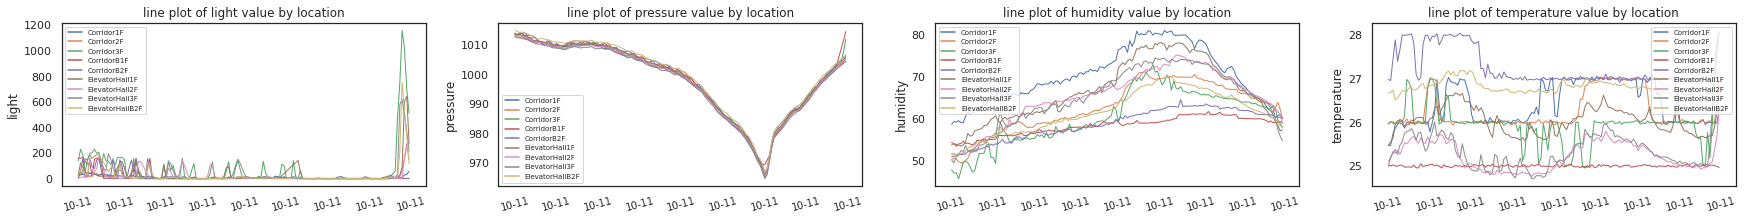

In [26]:
x_axis='new_tsp'
lineplotParams(new_sample_df,x_axis,sample_frec)

0 light AxesSubplot(0.125,0.125;0.168478x0.755)
1 pressure AxesSubplot(0.327174,0.125;0.168478x0.755)
2 humidity AxesSubplot(0.529348,0.125;0.168478x0.755)
3 temperature AxesSubplot(0.731522,0.125;0.168478x0.755)


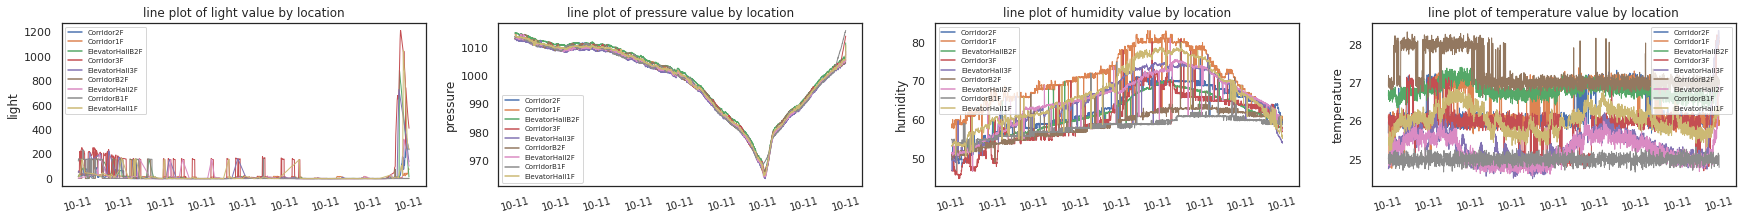

In [22]:
def lineplotParams(spec_date_pd,x_axis,name):
    #left  = 0.125  # the left side of the subplots of the figure
    #right = 0.9    # the right side of the subplots of the figure
    bottom = 0.1  # the bottom of the subplots of the figure
    top = 0.2      # the top of the subplots of the figure
    wspace = 0.2   # the amount of width reserved for blank space between subplots,
                   # expressed as a fraction of the average axis width
    hspace = 0.5   # the amount of height reserved for white space between subplots,
                   # expressed as a fraction of the average axis height

    sns.set_style(style='white')
    sns.color_palette("Spectral")
    col_name=['light','pressure','humidity','temperature']
    hori_no=2
    
    fig, axs = plt.subplots(1,len(col_name),figsize=(30,3))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=wspace, hspace=hspace)
    
    #fig, axs = plt.subplots(int(len(col_name)/hori_no),hori_no,figsize=(4,8))
    spec_date_pd["date_str"]=pd.to_datetime(spec_date_pd["new_tsp"]).apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S')[5:10])
    #print(spec_date_pd)
    #spec_date_pd["date_str"]=pd.to_datetime(spec_date_pd["new_tsp"]).apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S')[5:10])
    #print(spec_date_pd["date"].head(5),spec_date_pd["date_str"].head(5))
    if x_axis=="":
        x_axis="date_str"
    else:
        x_axis=="new_tsp"
        
    for i, each in enumerate(col_name):
        print(i, each, axs[i])
            #sns.lineplot(data=spec_date_pd,x="date_str", linewidth=1, y=each,hue="location")
        sns.lineplot(data=spec_date_pd,x=x_axis, linewidth=1, y=each,hue="location",ax=axs[i])
        #sns.scatterplot(data=spec_date_pd.dropna(),x=x_axis, y=each,hue="location",ax=axs[i])
        axs[i].legend(loc='best',fontsize=7)
        axs[i].set_xticklabels(spec_date_pd["date_str"], fontsize=10,rotation=15)  
        #axs[i].set_xticks(fontsize = 10,rotation=45)
        axs[i].set_xlabel('', size = 12); 
        #axs[i].set_ylabel('Value', size = 12); 
        axs[i].set_title('line plot of '+each+' value by location', size = 12);
   
    plt.savefig('./images/per'+each+name+'.png',quality=100,dpi=500, bbox_inches = 'tight') 
    plt.show()
    
x_axis='new_tsp'

lineplotParams(specdf,x_axis,'orig')

In [223]:
# print(specdf['location'].unique())
# #print(new_sample_df['Location'].unique())

# print(new_sample_df["new_tsp"])
# new_sample_df[1000:]
# col_name=['light','pressure','humidity','temperature']
# new_sample_df=new_sample_df.rename(columns={'location':'Location'})
# for i, each in enumerate(col_name):
#     sns.lineplot(data=new_sample_df,x="new_tsp", linewidth=1, y=each,hue="Location")
#     plt.show()
# #lineplotParams(specdf,x_axis)

In [10]:
start='2019-10-11 00:00:00'
end='2019-10-13 23:59:00'
specdf=getSpecdf(all_data,start,end)
print(specdf.shape)
mu, sigma = 0, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma, len(specdf['pressure']))
print(s)
for i, para in enumerate(['light','pressure','humidity','temperature']):
    specdf[para]=specdf[para]+s
#specdf.tail(10)
# print(specdf['location'].unique())
# for each in specdf['location'].unique():
#     loc_pd=specdf.loc[specdf['location']==each]
#     print(loc_pd['temperature'].iloc[0],str(loc_pd['temperature'].iloc[0])[3:7])
#     if len(str(loc_pd['temperature'].iloc[0]))==4 or str(loc_pd['temperature'])[3:7]=='000':
#         print("----4-----")
#         s = np.random.normal(mu, sigma, len(loc_pd['temperature']))
#         print(s,len(s))
#         specdf.loc[specdf['location']==each]['temperature']=specdf.loc[specdf['location']==each]['temperature']+s
#         print(specdf.loc[specdf['location']==each]['temperature'])
#         #loc_pd['temperature'].apply(lambda x: x+np.random.normal(mu, sigma, 1) if len(str(x))== 4 else x)

specdf

ElevatorHallB2F    2710
ElevatorHall2F     2706
ElevatorHall3F     2678
ElevatorHall1F     2651
CorridorB2F        2643
CorridorB1F        2637
Corridor2F         2620
Corridor1F         2617
Corridor3F         2601
dtype: int64
(23863, 13)
[-0.31295952  0.154644   -0.09411961 ... -0.20968341  0.15276232
  0.09030952]


,location,temperature,new_tsp,humidity,light,pressure,weekday,quarter,month,hour,day,location_no,floor_no
733481,Corridor2F,25.687040,2019-10-11 00:00:11,49.687040,18.219454,1013.571318,5,4,10,0,11,8,3
733482,Corridor1F,26.154644,2019-10-11 00:00:17,58.154644,13.371278,1014.686753,5,4,10,0,11,6,2
733483,ElevatorHallB2F,26.653164,2019-10-11 00:00:30,51.163768,17.515464,1015.102940,5,4,10,0,11,1,0
733484,Corridor3F,26.086586,2019-10-11 00:00:39,47.086586,57.094185,1013.067686,5,4,10,0,11,10,4
733485,ElevatorHall3F,24.755973,2019-10-11 00:00:40,50.603346,51.755347,1012.685467,5,4,10,0,11,9,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
757339,ElevatorHall3F,28.162754,2019-10-12 23:59:32,54.050361,137.433848,1004.532862,6,4,10,23,12,9,4
757340,CorridorB2F,27.076835,2019-10-12 23:59:33,60.076835,0.563235,1005.667321,6,4,10,23,12,2,0
757341,CorridorB1F,24.790317,2019-10-12 23:59:42,58.790317,2.222317,1015.943035,6,4,10,23,12,4,1
757342,ElevatorHall2F,26.945370,2019-10-12 23:59:51,57.538417,103.174749,1008.578881,6,4,10,23,12,7,3


In [11]:
x_axis='new_tsp'
#plotname="resample_60s"
lineplotParams(new_sample_df,x_axis,sample_frec)

NameError: name 'new_sample_df' is not defined

In [320]:
all_file_data=all_data.copy()
columns=all_data.columns

print('before processing outlier; min:', np.nanmin(all_file_data['light']),'max:', np.nanmax(all_file_data['light']))

all_file_data['light'] = cap_values(all_data['light'])

#after processing outlier; min: 0.0 max: 335.543914321829
print('after processing outlier; min:', np.nanmin(all_file_data['light']),'max:', np.nanmax(all_file_data['light']))
#all_file_data.index = pd.to_datetime(all_file_data['new_tsp']).sort_index()
all_file_data
#all_file_data.info()
#all_file_data.describe()
# res_data=all_file_data.resample('600s').mean().sort_index()
# res_data

before processing outlier; min: 0.0 max: 9607.5
Size of outliers: 96036 Size of normal data:  1163157
after processing outlier; min: 0.0 max: 445.980983308794


,location,temperature,new_tsp,humidity,light,pressure,weekday,quarter,month,hour,day,location_no,floor_no
0,ElevatorHall1F,26.768128,2020-05-03 00:00:06,46.338968,232.162997,1012.104684,7,2,5,0,3,5,2
1,ElevatorHallB2F,24.168304,2020-05-03 00:00:18,51.785765,195.929840,1013.288941,7,2,5,0,3,1,0
2,ElevatorHall3F,29.677198,2020-05-03 00:00:22,35.616150,219.469723,1010.701637,7,2,5,0,3,9,4
3,CorridorB1F,22.000000,2020-05-03 00:00:28,57.000000,2.432000,1012.501536,7,2,5,0,3,4,1
4,Corridor1F,27.000000,2020-05-03 00:00:34,50.000000,218.609881,1012.347484,7,2,5,0,3,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1259188,ElevatorHall3F,20.194169,2019-11-16 23:59:21,38.473075,34.938268,1017.371148,6,4,11,23,16,9,4
1259189,Corridor3F,20.000000,2019-11-16 23:59:24,39.000000,34.938268,1016.970661,6,4,11,23,16,10,4
1259190,CorridorB1F,21.000000,2019-11-16 23:59:35,54.000000,2.432000,1017.331088,6,4,11,23,16,4,1
1259191,CorridorB2F,24.000000,2019-11-16 23:59:40,34.000000,0.486400,1017.609541,6,4,11,23,16,2,0


In [298]:
sample_frec="10min"

all_file_data=all_data.copy()

all_file_data.index = pd.to_datetime(all_file_data['new_tsp'])

for i, para in enumerate(['light','pressure','humidity','temperature']):
    print(para)
    #res_para =  all_file_data.groupby('location').apply(lambda g: g[para].resample('300s').interpolate()).reset_index()
    res_para =all_file_data.groupby('location')[para].resample(sample_frec).mean().reset_index()
    
    print(res_para.shape)
    #print(res_para.head(5))
    # #new_sample_df=pd.DataFrame(columns=[])

    if i ==0:
        new_sample_df=res_para
    else:
        new_sample_df=pd.merge(left=res_para,right=new_sample_df, on=['new_tsp','location'],how='left')
print(new_sample_df.shape)
print(new_sample_df.isnull().sum())
new_sample_df.dropna()
#print(new_sample_df.dropna().shape)

light
(561058, 3)
pressure
(561058, 3)
humidity
(561058, 3)
temperature
(561058, 3)
(561058, 6)
location            0
new_tsp             0
temperature    426480
humidity       426480
pressure       426492
light          426493
dtype: int64


,location,new_tsp,temperature,humidity,pressure,light
5,Corridor1F,2019-07-07 15:50:00,24.000000,66.333333,1006.945919,18.817795
6,Corridor1F,2019-07-07 16:00:00,24.100000,65.250000,1006.953139,14.086636
7,Corridor1F,2019-07-07 16:10:00,24.555556,64.888889,1007.384103,9.330721
8,Corridor1F,2019-07-07 16:20:00,24.900000,64.200000,1007.910518,0.486400
9,Corridor1F,2019-07-07 16:30:00,24.875000,64.000000,1008.113545,0.486400
...,...,...,...,...,...,...
561053,ElevatorHallB2F,2020-12-12 23:10:00,23.397443,32.606419,1008.324787,751.277457
561054,ElevatorHallB2F,2020-12-12 23:20:00,23.330416,32.858028,1008.320252,751.277457
561055,ElevatorHallB2F,2020-12-12 23:30:00,23.244679,33.014558,1008.309325,751.277457
561056,ElevatorHallB2F,2020-12-12 23:40:00,23.116205,33.412755,1008.397874,751.277457


In [299]:
new_sample_df=setfeatures(new_sample_df.dropna())
new_sample_df

,location,new_tsp,temperature,humidity,pressure,light,weekday,quarter,month,hour,day,location_no,floor_no
5,Corridor1F,2019-07-07 15:50:00,24.000000,66.333333,1006.945919,18.817795,7,3,7,15,7,6,2
6,Corridor1F,2019-07-07 16:00:00,24.100000,65.250000,1006.953139,14.086636,7,3,7,16,7,6,2
7,Corridor1F,2019-07-07 16:10:00,24.555556,64.888889,1007.384103,9.330721,7,3,7,16,7,6,2
8,Corridor1F,2019-07-07 16:20:00,24.900000,64.200000,1007.910518,0.486400,7,3,7,16,7,6,2
9,Corridor1F,2019-07-07 16:30:00,24.875000,64.000000,1008.113545,0.486400,7,3,7,16,7,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
561053,ElevatorHallB2F,2020-12-12 23:10:00,23.397443,32.606419,1008.324787,751.277457,6,4,12,23,12,1,0
561054,ElevatorHallB2F,2020-12-12 23:20:00,23.330416,32.858028,1008.320252,751.277457,6,4,12,23,12,1,0
561055,ElevatorHallB2F,2020-12-12 23:30:00,23.244679,33.014558,1008.309325,751.277457,6,4,12,23,12,1,0
561056,ElevatorHallB2F,2020-12-12 23:40:00,23.116205,33.412755,1008.397874,751.277457,6,4,12,23,12,1,0


In [300]:
new_sample_df.to_csv('DB/new_data/allData_resample_10m.csv', index = False)

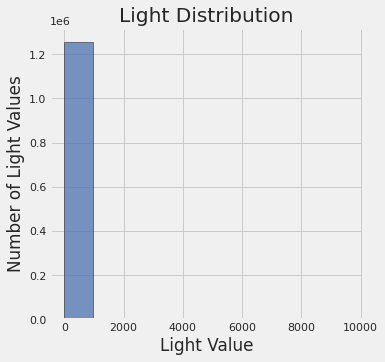

In [191]:
# figsize(5, 5)

# plt.style.use('fivethirtyeight')
# sns.histplot(all_file_data['light'].dropna(), bins = 10, edgecolor = 'k');
# plt.xlabel('Light Value'); plt.ylabel('Number of Light Values'); 
# plt.title('Light Distribution');
# plt.show()

In [25]:
all_file_data.head(10)

,location,new_tsp,temperature,humidity,pressure,light,weekday,quarter,month,hour,day,location_no,floor_no
0,Corridor1F,2019-07-07 15:00:00,19.500000,79.750000,1007.188204,2.886939,7,3,7,15,7,6,2
1,Corridor1F,2019-07-07 15:10:00,21.500000,76.600000,1007.188204,18.918915,7,3,7,15,7,6,2
2,Corridor1F,2019-07-07 15:20:00,23.000000,71.875000,1007.188204,15.082670,7,3,7,15,7,6,2
3,Corridor1F,2019-07-07 15:30:00,23.666667,69.222222,1007.188204,13.837628,7,3,7,15,7,6,2
4,Corridor1F,2019-07-07 15:40:00,24.000000,67.400000,1007.188204,16.125012,7,3,7,15,7,6,2
5,Corridor1F,2019-07-07 15:50:00,24.000000,66.333333,1007.134363,18.817795,7,3,7,15,7,6,2
6,Corridor1F,2019-07-07 16:00:00,24.100000,65.300000,1006.703633,14.335644,7,3,7,16,7,6,2
7,Corridor1F,2019-07-07 16:10:00,24.555556,64.888889,1006.703633,9.330721,7,3,7,16,7,6,2
8,Corridor1F,2019-07-07 16:20:00,24.900000,64.200000,1007.366693,0.486400,7,3,7,16,7,6,2
9,Corridor1F,2019-07-07 16:30:00,24.875000,64.000000,1008.234094,0.486400,7,3,7,16,7,6,2


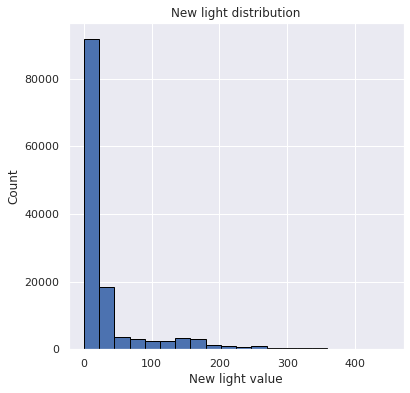

In [26]:
# Histogram Plot of new light data
figsize(6, 6)
plt.hist(all_file_data['light'].dropna(), bins = 20, edgecolor = 'black');
plt.xlabel('New light value'); 
plt.ylabel('Count'); plt.title('New light distribution');
#print(len(new_light_data['light'].dropna().sort_values()),len(new_light_data.loc[new_light_data['light'] < 10, :]))

In [35]:
#print(len(all_file_data['light'].dropna().sort_values()),len(all_file_data.loc[all_file_data['light'] > 100, :]),len(all_file_data.loc[all_file_data['light'] < 100, :]))

1259193 204676 1054495


In [2]:
figsize(8, 14)
sns.color_palette("Spectral", as_cmap=True)
# Rename the score 
#all_file_data = all_file_data.rename(columns = {'col_a': 'col_b'})
col_name=['temperature', 'humidity','light','pressure']
fig, axs = plt.subplots(len(col_name),1,figsize=(10,12))
#print(len(col_name))

wspace = 0.1   # the amount of width reserved for blank space between subplots,
               # expressed as a fraction of the average axis width
hspace = 0.3   # the amount of height reserved for white space between subplots,
               # expressed as a fraction of the average axis height

sns.set_style(style='white')
sns.color_palette("Spectral")

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
            wspace=wspace, hspace=hspace)
for i, each in enumerate(col_name):
    
    #print(each)
# Histogram of columns
    #plt.style.use('fivethirtyeight')
    sns.histplot(data=all_file_data[each].dropna(), bins = 10, edgecolor = 'k', ax=axs[i],label=each,shrink=.9)
    axs[i].legend(loc='upper left')
    #plt.hist(all_file_data[each].dropna(), bins = 100, edgecolor = 'k', ax=axs[i]);
    # sns.lineplot(duple_df_9["time"],duple_df_9["instance"], drawstyle='steps-mid', ax=axs[i],label=v,linewidth=1)
    plt.xlabel(each,size = 14); 
    #plt.ylabel('Values of'+each); 
    #plt.title(each);
plt.savefig('./images/stat.png',quality=100,dpi=500, bbox_inches = 'tight') 
plt.show()

NameError: name 'figsize' is not defined

reference [离群点](https://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm)

### 剔除离群点

离群点的选择可能需要再斟酌一些，这里选择的方法是extreme outlier。

*   $\text{First Quartile} -3 * \text{Interquartile Range}$
*   $\text{Third Quartile} + 3 * \text{Interquartile Range}$

In [46]:
# # Calculate first and third quartile
# first_quartile =all_file_data['light'].describe()['25%']
# third_quartile =all_file_data['light'].describe()['75%']

# # Interquartile range
# iqr = third_quartile - first_quartile

# # Remove outliers
# all_file_data = all_file_data[(all_file_data['light']> (first_quartile - 3 * iqr)) &
#             (all_file_data['light'] < (third_quartile + 3 * iqr))]

### 观察哪些变量会对结果产生影响

kdeplot这个最实用啦 [density plot](https://datavizcatalogue.com/methods/density_plot.html) 

选择大于100条数据的

In [5]:
# Create a list of  locations with more than 100 measurements
types = all_file_data.dropna(subset=['location'])
types = types['location'].value_counts()
#types = list(types[types.values > 100].index)
print(types)

ElevatorHall3F     194495
ElevatorHallB2F    193975
ElevatorHall1F     155448
Corridor3F         154291
CorridorB1F        125445
Corridor2F         115383
ElevatorHall2F     113407
Corridor1F         107702
CorridorB2F         73786
ElevatorHallB1F     25261
Name: location, dtype: int64


ElevatorHall1F
ElevatorHallB2F
ElevatorHall3F
CorridorB1F
Corridor1F
Corridor3F
Corridor2F
ElevatorHall2F
CorridorB2F
ElevatorHallB1F


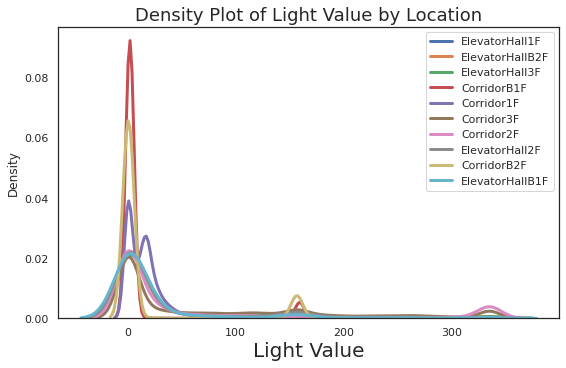

In [32]:
# Plot of distribution of scores for location categories
import seaborn as sns; sns.set_style(style='white')
#sns.set_theme()
#sns.husl_palette(len(types))
sns.color_palette("Spectral")

figsize(8, 5)
#sns.color_palette("Spectral")

types=all_file_data['location'].unique()
# Plot each location
for l_type in types:
    # Select the location type
    subset =  all_file_data[all_file_data['location'] == l_type]
    print(l_type)
    # Density plot of Energy Star scores
    sns.kdeplot(subset['light'].dropna(),label = l_type,  linewidth=3,  alpha = 0.8);#,shade = False,
    
# label the plot
plt.legend()
plt.xlabel('Light Value', size = 20); plt.ylabel('Density', size = 12); 
plt.title('Density Plot of Light Value by Location', size = 18);
#diiferent Value density in locations

plt.savefig('./images/light.png',quality=100,dpi=500, bbox_inches = 'tight') 

ElevatorHall1F
ElevatorHallB2F
ElevatorHall3F
CorridorB1F
Corridor1F
Corridor3F
Corridor2F
ElevatorHall2F
CorridorB2F
ElevatorHallB1F


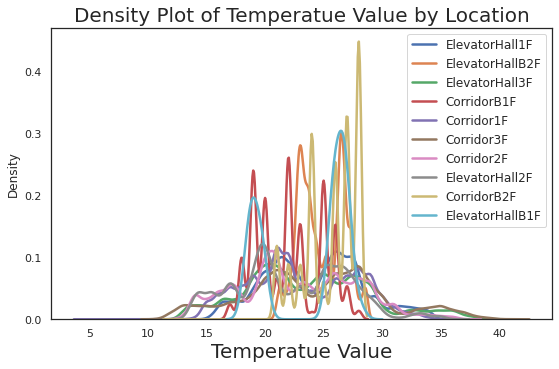

In [34]:
figsize(8, 5)

# Plot each location
for l_type in types:
    # Select the building type
    subset =  all_file_data[all_file_data['location'] == l_type]
    print(l_type)
    # Density plot of Energy Star scores
    sns.kdeplot(subset['temperature'].dropna(),
               label = l_type,  alpha = 0.8, linewidth=2.5);#,shade = False,
    
# label the plot
plt.legend(fontsize = 12)
plt.xlabel('Temperatue Value', size = 20); plt.ylabel('Density', size = 12); 
plt.title('Density Plot of Temperatue Value by Location', size = 20);
plt.savefig('./images/Temperatue.png',quality=100,dpi=500,bbox_inches = 'tight') 

ElevatorHall1F
ElevatorHallB2F
ElevatorHall3F
CorridorB1F
Corridor1F
Corridor3F
Corridor2F
ElevatorHall2F
CorridorB2F
ElevatorHallB1F


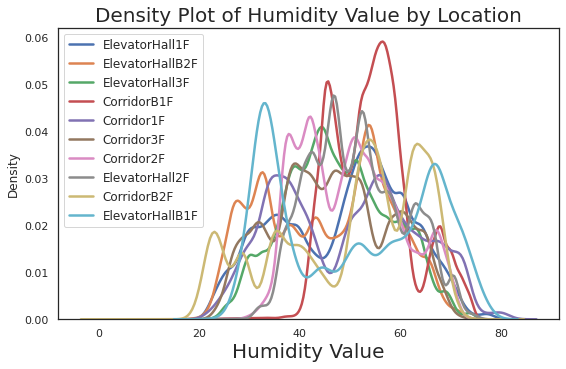

In [35]:
figsize(8, 5)

# Plot each location
for l_type in types:
    # Select the building type
    subset =  all_file_data[all_file_data['location'] == l_type]
    print(l_type)
    # Density plot of Energy Star scores
    sns.kdeplot(subset['humidity'].dropna(),
               label = l_type,  alpha = 0.8, linewidth=2.5);#,shade = False,
    
# label the plot
plt.legend(fontsize = 12)
plt.xlabel('Humidity Value', size = 20); plt.ylabel('Density', size = 12); 
plt.title('Density Plot of Humidity Value by Location', size = 20);
plt.savefig('./images/Humidity.png',quality=100,dpi=500,bbox_inches = 'tight') 


ElevatorHall1F
ElevatorHallB2F
ElevatorHall3F
CorridorB1F
Corridor1F
Corridor3F
Corridor2F
ElevatorHall2F
CorridorB2F
ElevatorHallB1F


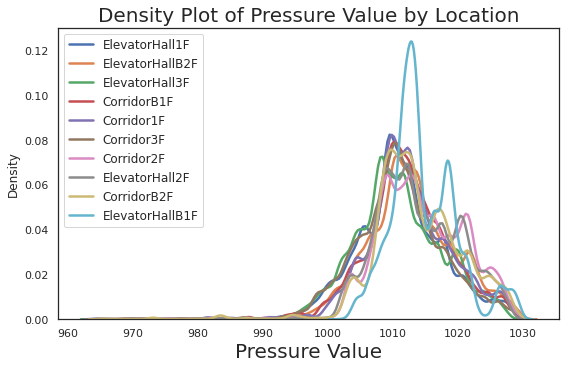

In [40]:
figsize(8, 5)


# Plot each location
for l_type in types:
    # Select the building type
    subset =  all_file_data[all_file_data['location'] == l_type]
    print(l_type)
    # Density plot of Energy Star scores
    sns.kdeplot(subset['pressure'].dropna(),
               label = l_type,  alpha = 0.8,linewidth=2.5);#,shade = False,
    
# label the plot
plt.legend(fontsize = 12)
plt.xlabel('Pressure Value', size = 20); plt.ylabel('Density', size = 12); 
plt.title('Density Plot of Pressure Value by Location', size = 20);

fig.subplots_adjust(left=0.8)

plt.savefig('./images/pressure.png',quality=100,dpi=500, bbox_inches = 'tight') 

### 特征和标签之间的相关性

Pearson相关系数，帮助我们来筛选特征

![](images/correlation_examples.png)


In [22]:
smaple='1m'
data_file='allData_resample_'+smaple
#allData_resample_15m
pre_targets='floor_no'#'location_no'

df=pd.read_csv('DB/new_data/'+data_file+'.csv')

#corr_df=all_file_data.corr().round(3)
# formater= lambda x:"{0:.03f}".format
# corr_df=corr_df.applymap(formater)
df=df.drop(columns=(['Unnamed: 0','location','new_tsp','location_no','floor_no']))


In [23]:
corr_df=df.corr().round(3)
corr_df

,temperature,humidity,pressure,light,weekday,quarter,month,hour,day
temperature,1.000,0.418,-0.282,0.037,0.011,0.127,0.094,-0.039,-0.016
humidity,0.418,1.000,-0.332,-0.176,-0.034,0.268,0.194,0.073,0.174
pressure,-0.282,-0.332,1.000,0.065,0.074,0.232,0.265,0.047,0.113
light,0.037,-0.176,0.065,1.000,-0.020,0.161,0.196,-0.058,-0.113
weekday,0.011,-0.034,0.074,-0.020,1.000,-0.041,-0.041,0.005,-0.108
quarter,0.127,0.268,0.232,0.161,-0.041,1.000,0.967,-0.008,0.188
month,0.094,0.194,0.265,0.196,-0.041,0.967,1.000,-0.007,0.248
hour,-0.039,0.073,0.047,-0.058,0.005,-0.008,-0.007,1.000,-0.007
day,-0.016,0.174,0.113,-0.113,-0.108,0.188,0.248,-0.007,1.000


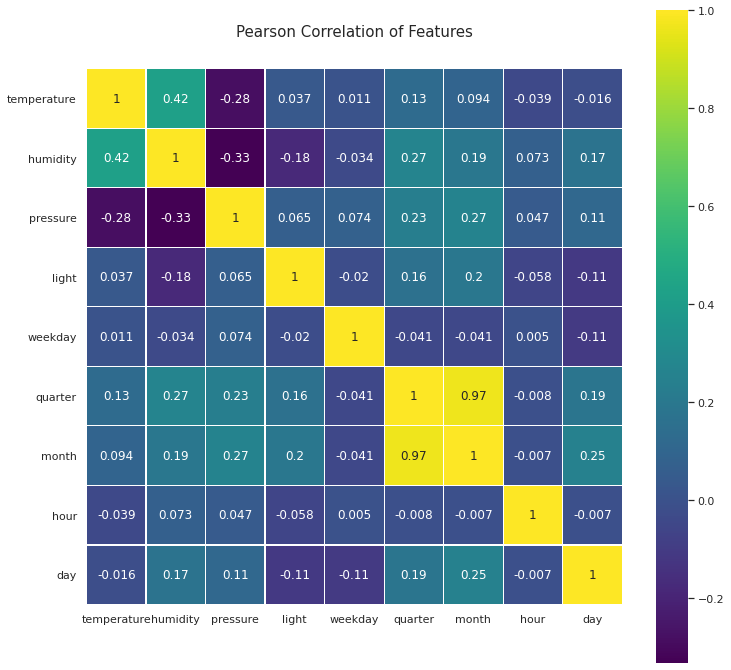

In [24]:
sns.set_style(style='white')

colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(corr_df,linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
plt.savefig('./images/corr.png',quality=100,dpi=500,bbox_inches = 'tight')

In [191]:
# Find all correlations and sort 
correlations_data = corr_df['temperature'].sort_values()
# Print the most negative correlations
print(correlations_data.head(15), '\n')

# Print the most positive correlations print(correlations_data.tail(15))

pressure      -0.281
location_no   -0.086
hour          -0.039
day           -0.016
weekday        0.011
light          0.060
month          0.093
quarter        0.126
humidity       0.418
temperature    1.000
Name: temperature, dtype: float64 



`pressure`和  `temperature` 呈现出明显的负相关，

`humidity`和`temperature`呈现出明显的正相关，

`pressure`和 `temperature`呈现出明显的相关

还需要在考虑下非线性变换的特征，比如平方，log等等，都可以来试试，对于类别变量还可以用one-hot encode来转换下。

In [163]:
# # Select the numeric columns
# numeric_subset = all_file_data.select_dtypes('number')

# # Create columns with square root and log of numeric columns
# for col in numeric_subset.columns:
#     # Skip the Energy Star Score column
#     if col == 'temperature':
#         next
#     else:
#         numeric_subset['sqrt_' + col] = np.sqrt(numeric_subset[col])
#         numeric_subset['log_' + col] = np.log(numeric_subset[col])

# # Select the categorical columns
# #categorical_subset = all_file_data[['location']]
# #print(categorical_subset.columns)
# # One hot encode
# #categorical_subset = pd.get_dummies(categorical_subset)
# #print(categorical_subset.columns)
# # Join the two dataframes using concat
# # Make sure to use axis = 1 to perform a column bind
# features = pd.concat([numeric_subset, all_file_data['location']], axis = 1)

# print(features.shape)
# # Drop buildings without an energy star score
# features = features.dropna(subset = ['temperature'])

# # Find correlations with the score 
# correlations = features.corr()['temperature'].dropna().sort_values()

# # Display most positive correlations看起来经过变换后的特征并没有出现一些新面孔，本来比较强的变换后依旧比较强。值得一提的是类别变量one-hot encode之后成为了正相关中最强的，虽然数值还是比较低。
# correlations.head(15)

(1259193, 29)


pressure           -0.280695
sqrt_pressure      -0.280349
log_pressure       -0.279999
log_location_no    -0.118688
sqrt_location_no   -0.103920
location_no        -0.085559
hour               -0.039288
sqrt_hour          -0.031686
log_hour           -0.028166
day                -0.015578
sqrt_day           -0.007701
log_day            -0.000473
log_weekday         0.000223
sqrt_weekday        0.005591
weekday             0.010923
Name: temperature, dtype: float64

In [82]:


#features.index = features['new_tsp']

features

,location,temperature,new_tsp,humidity,light,pressure,weekday,quarter,month,hour,day,location_no
0,ElevatorHall1F,26.768128,2020-05-03 00:00:06,46.338968,NaN,1012.104684,7,2,5,0,3,5
1,ElevatorHallB2F,24.168304,2020-05-03 00:00:18,51.785765,NaN,1013.288941,7,2,5,0,3,1
2,ElevatorHall3F,29.677198,2020-05-03 00:00:22,38.256116,NaN,1010.999658,7,2,5,0,3,9
3,CorridorB1F,22.000000,2020-05-03 00:00:28,57.000000,2.432000,1011.605575,7,2,5,0,3,4
4,Corridor1F,27.000000,2020-05-03 00:00:34,50.000000,218.609881,1012.090911,7,2,5,0,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...
1259188,ElevatorHall3F,20.194169,2019-11-16 23:59:21,38.473075,NaN,1017.371148,6,4,11,23,16,9
1259189,Corridor3F,20.000000,2019-11-16 23:59:24,39.000000,335.543914,1018.749121,6,4,11,23,16,10
1259190,CorridorB1F,21.000000,2019-11-16 23:59:35,51.000000,NaN,1017.854514,6,4,11,23,16,4
1259191,CorridorB2F,24.000000,2019-11-16 23:59:40,34.000000,0.486400,1017.641326,6,4,11,23,16,2


In [168]:
# Copy the original data
# features = all_file_data.copy()

# all_file_data.head(20)

# # Select the numeric columns
# numeric_subset = all_file_data.select_dtypes('number')

# # Create columns with log of numeric columns
# for col in numeric_subset.columns:
#     # Skip the Energy Star Score column
#     if col == 'score':
#         next
#     else:
#         numeric_subset['log_' + col] = np.log(numeric_subset[col])
#         numeric_subset['sqrt_' + col] = np.sqrt(numeric_subset[col])
# # Select the categorical columns
# #categorical_subset = all_file_data[[]]

# # One hot encode
# categorical_subset = pd.get_dummies(numeric_subset)

# # Join the two dataframes using concat
# # Make sure to use axis = 1 to perform a column bind
# features = pd.concat([numeric_subset, categorical_subset], axis = 1)

# print(features.shape)
# features.head(10)

(1259193, 60)


,temperature,humidity,light,pressure,weekday,quarter,month,hour,day,location_no,log_temperature,sqrt_temperature,log_humidity,sqrt_humidity,log_light,sqrt_light,log_pressure,sqrt_pressure,log_weekday,sqrt_weekday,log_quarter,sqrt_quarter,log_month,sqrt_month,log_hour,sqrt_hour,log_day,sqrt_day,log_location_no,sqrt_location_no,temperature,humidity,light,pressure,weekday,quarter,month,hour,day,location_no,log_temperature,sqrt_temperature,log_humidity,sqrt_humidity,log_light,sqrt_light,log_pressure,sqrt_pressure,log_weekday,sqrt_weekday,log_quarter,sqrt_quarter,log_month,sqrt_month,log_hour,sqrt_hour,log_day,sqrt_day,log_location_no,sqrt_location_no
0,26.768128,46.338968,NaN,1012.104684,7,2,5,0,3,5,3.287212,5.173792,3.835983,6.807273,NaN,NaN,6.919787,31.813593,1.94591,2.645751,0.693147,1.414214,1.609438,2.236068,-inf,0.0,1.098612,1.732051,1.609438,2.236068,26.768128,46.338968,NaN,1012.104684,7,2,5,0,3,5,3.287212,5.173792,3.835983,6.807273,NaN,NaN,6.919787,31.813593,1.94591,2.645751,0.693147,1.414214,1.609438,2.236068,-inf,0.0,1.098612,1.732051,1.609438,2.236068
1,24.168304,51.785765,NaN,1013.288941,7,2,5,0,3,1,3.185042,4.916127,3.947115,7.196233,NaN,NaN,6.920957,31.832200,1.94591,2.645751,0.693147,1.414214,1.609438,2.236068,-inf,0.0,1.098612,1.732051,0.000000,1.000000,24.168304,51.785765,NaN,1013.288941,7,2,5,0,3,1,3.185042,4.916127,3.947115,7.196233,NaN,NaN,6.920957,31.832200,1.94591,2.645751,0.693147,1.414214,1.609438,2.236068,-inf,0.0,1.098612,1.732051,0.000000,1.000000
2,29.677198,38.256116,NaN,1010.999658,7,2,5,0,3,9,3.390379,5.447678,3.644303,6.185153,NaN,NaN,6.918695,31.796221,1.94591,2.645751,0.693147,1.414214,1.609438,2.236068,-inf,0.0,1.098612,1.732051,2.197225,3.000000,29.677198,38.256116,NaN,1010.999658,7,2,5,0,3,9,3.390379,5.447678,3.644303,6.185153,NaN,NaN,6.918695,31.796221,1.94591,2.645751,0.693147,1.414214,1.609438,2.236068,-inf,0.0,1.098612,1.732051,2.197225,3.000000
3,22.000000,57.000000,2.432000,1011.605575,7,2,5,0,3,4,3.091042,4.690416,4.043051,7.549834,0.888714,1.559487,6.919294,31.805748,1.94591,2.645751,0.693147,1.414214,1.609438,2.236068,-inf,0.0,1.098612,1.732051,1.386294,2.000000,22.000000,57.000000,2.432000,1011.605575,7,2,5,0,3,4,3.091042,4.690416,4.043051,7.549834,0.888714,1.559487,6.919294,31.805748,1.94591,2.645751,0.693147,1.414214,1.609438,2.236068,-inf,0.0,1.098612,1.732051,1.386294,2.000000
4,27.000000,50.000000,218.609881,1012.090911,7,2,5,0,3,6,3.295837,5.196152,3.912023,7.071068,5.387289,14.785462,6.919774,31.813376,1.94591,2.645751,0.693147,1.414214,1.609438,2.236068,-inf,0.0,1.098612,1.732051,1.791759,2.449490,27.000000,50.000000,218.609881,1012.090911,7,2,5,0,3,6,3.295837,5.196152,3.912023,7.071068,5.387289,14.785462,6.919774,31.813376,1.94591,2.645751,0.693147,1.414214,1.609438,2.236068,-inf,0.0,1.098612,1.732051,1.791759,2.449490
5,30.000000,38.000000,335.543914,1010.891355,7,2,5,0,3,10,3.401197,5.477226,3.637586,6.164414,5.815753,18.317858,6.918588,31.794518,1.94591,2.645751,0.693147,1.414214,1.609438,2.236068,-inf,0.0,1.098612,1.732051,2.302585,3.162278,30.000000,38.000000,335.543914,1010.891355,7,2,5,0,3,10,3.401197,5.477226,3.637586,6.164414,5.815753,18.317858,6.918588,31.794518,1.94591,2.645751,0.693147,1.414214,1.609438,2.236068,-inf,0.0,1.098612,1.732051,2.302585,3.162278
6,26.789767,46.293253,NaN,1012.104684,7,2,5,0,3,5,3.288020,5.175883,3.834996,6.803915,NaN,NaN,6.919787,31.813593,1.94591,2.645751,0.693147,1.414214,1.609438,2.236068,-inf,0.0,1.098612,1.732051,1.609438,2.236068,26.789767,46.293253,NaN,1012.104684,7,2,5,0,3,5,3.288020,5.175883,3.834996,6.803915,NaN,NaN,6.919787,31.813593,1.94591,2.645751,0.693147,1.414214,1.609438,2.236068,-inf,0.0,1.098612,1.732051,1.609438,2.236068
7,24.170546,51.790917,NaN,1013.275641,7,2,5,0,3,1,3.185135,4.916355,3.947215,7.196591,NaN,NaN,6.920944,31.831991,1.94591,2.645751,0.693147,1.414214,1.609438,2.236068,-inf,0.0,1.098612,1.732051,0.000000,1.000000,24.170546,51.790917,NaN,1013.275641,7,2,5,0,3,1,3.185135,4.916355,3.947215,7.196591,NaN,Na

### 双变量绘图

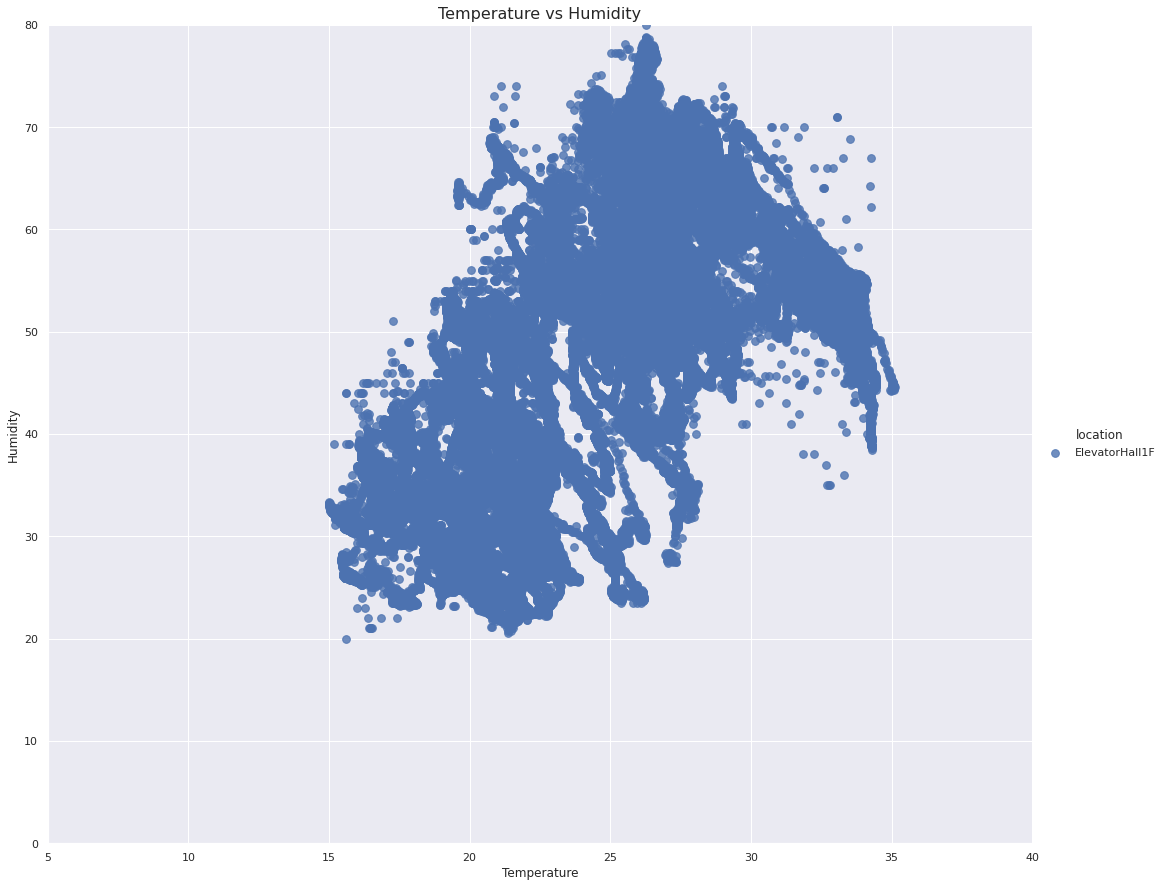

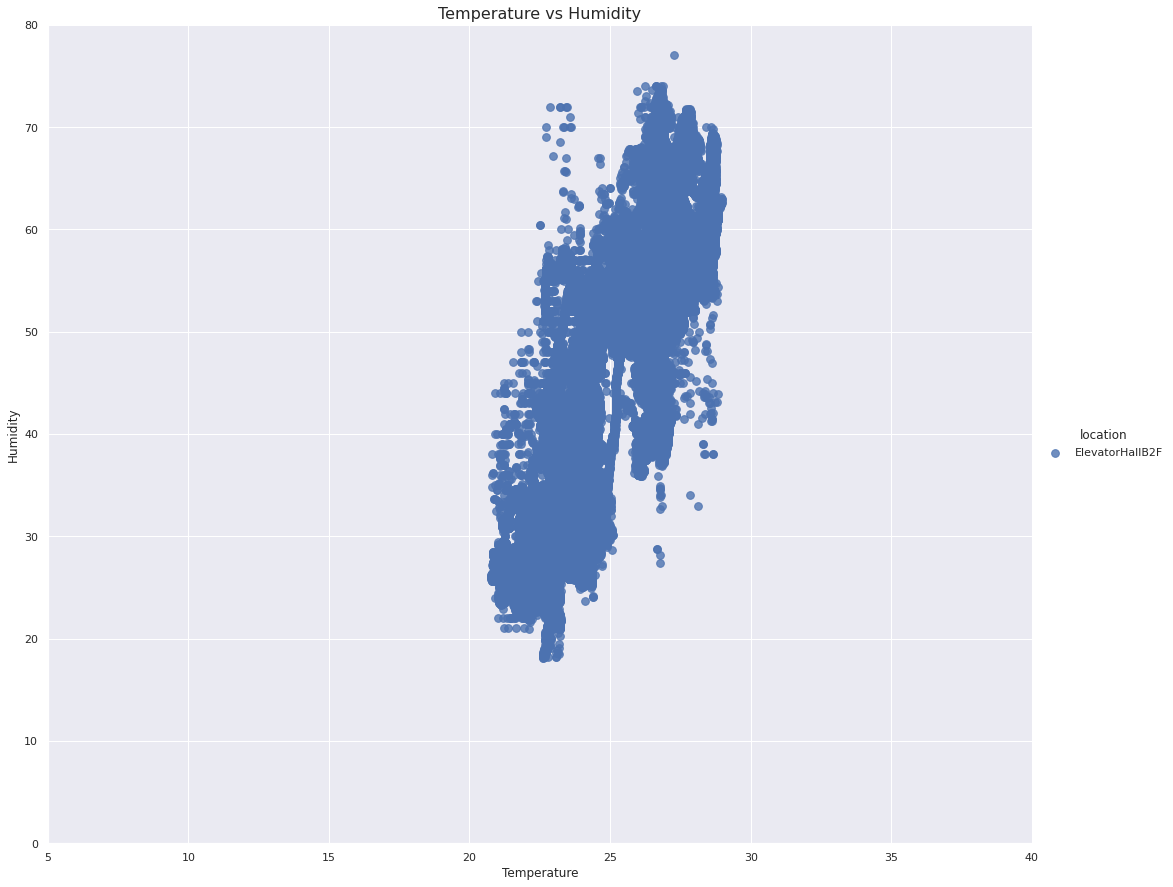

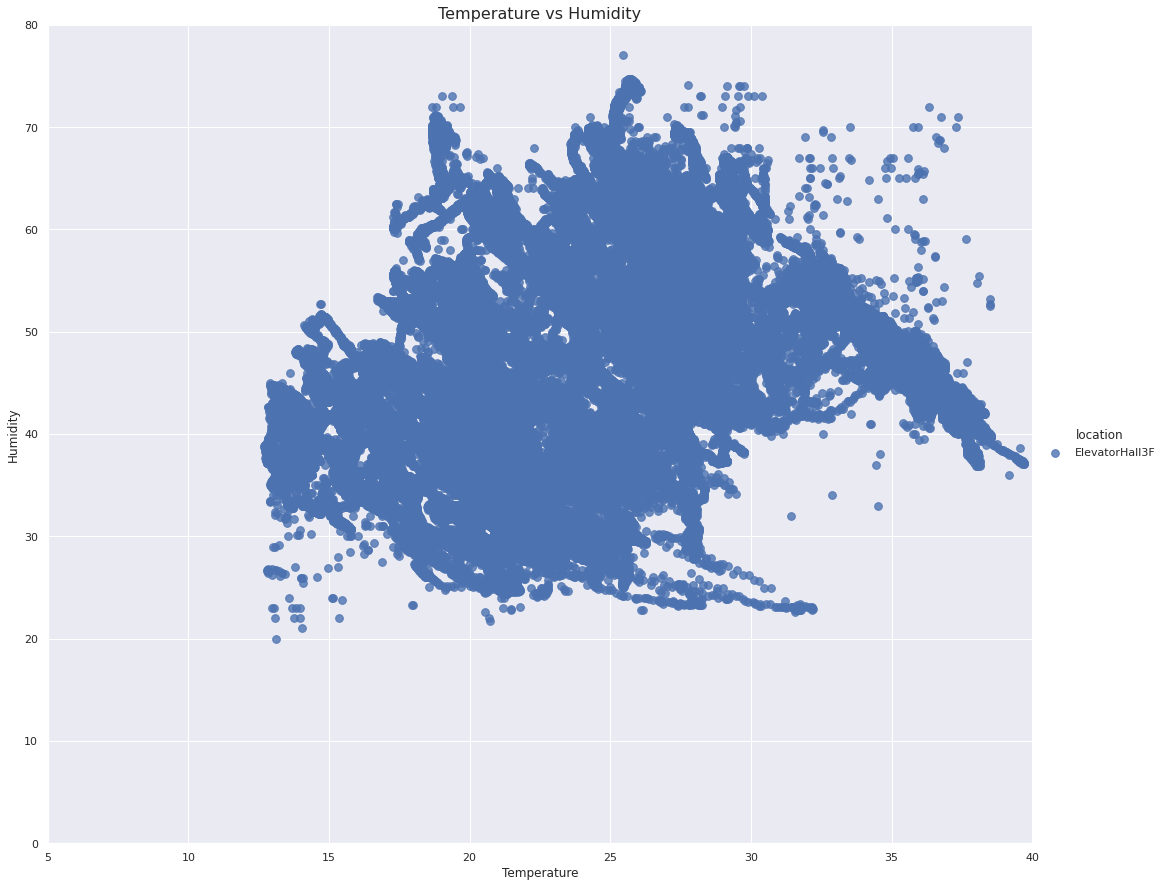

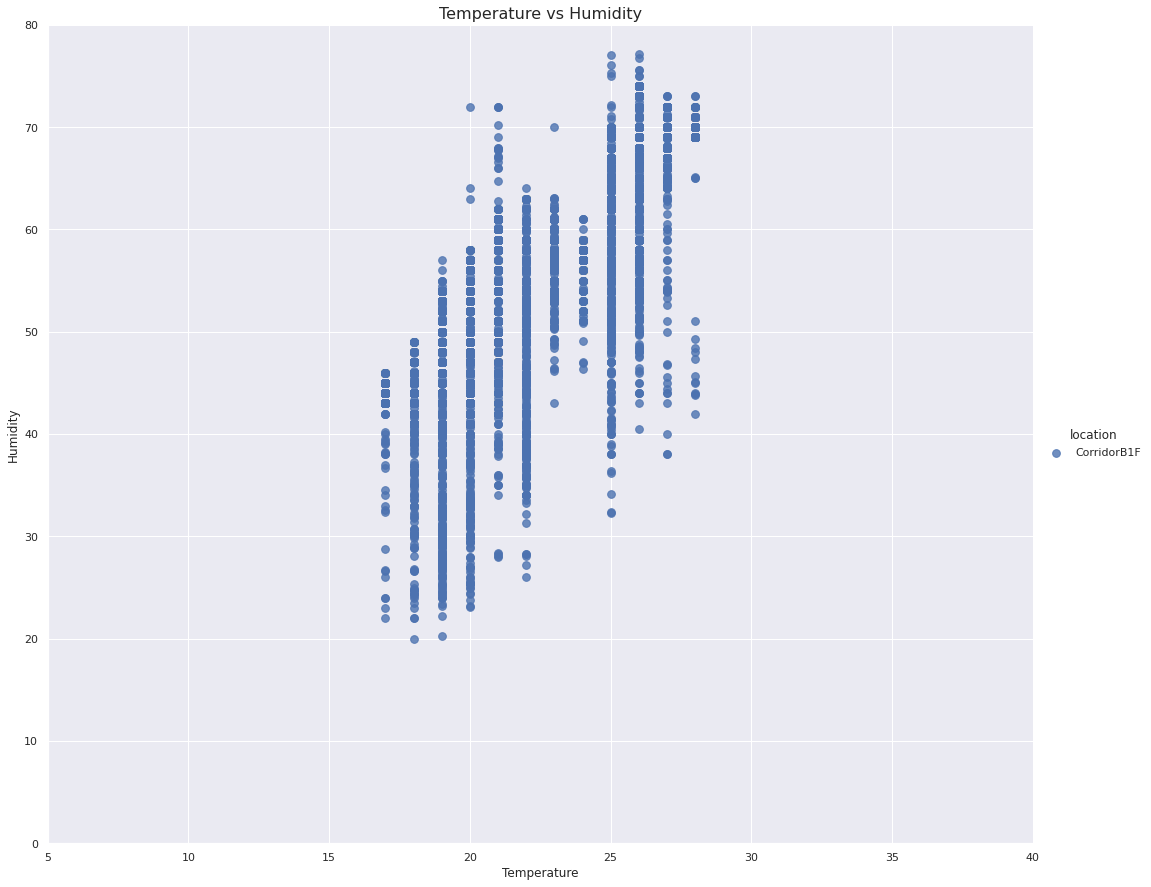

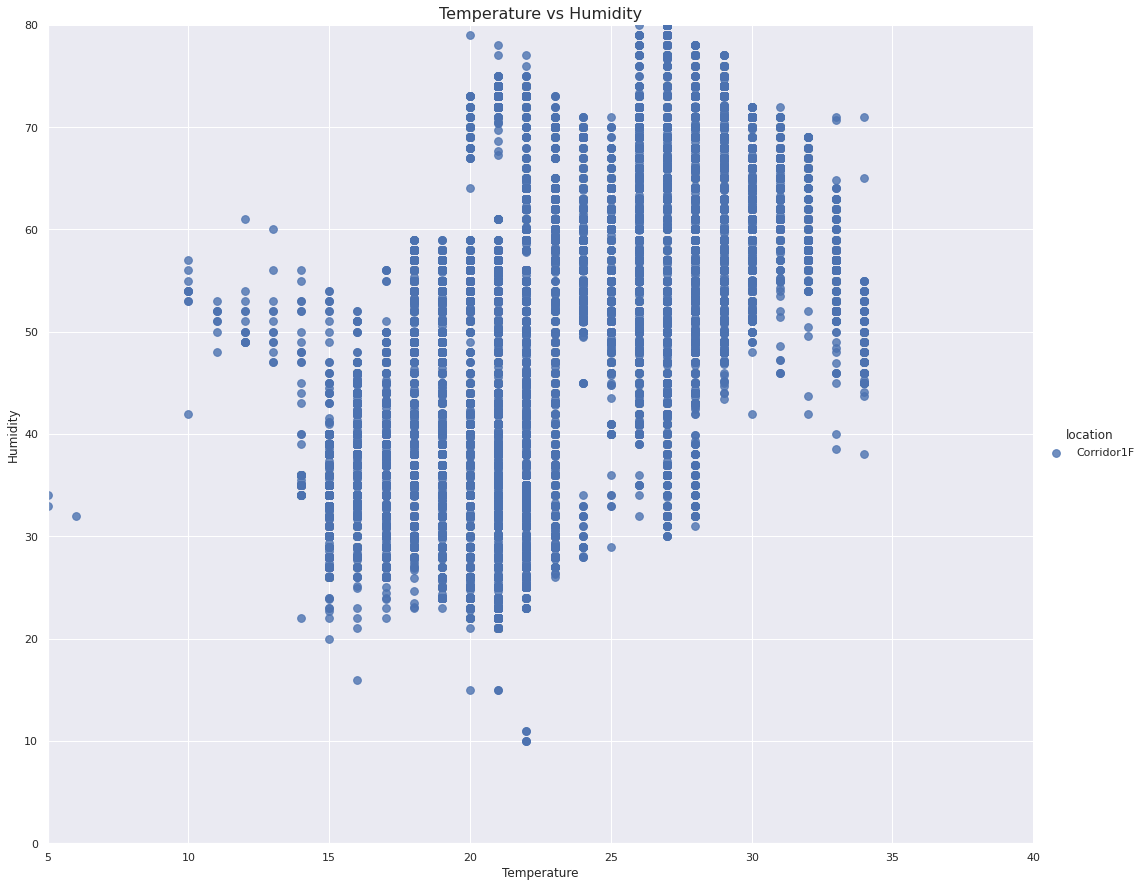

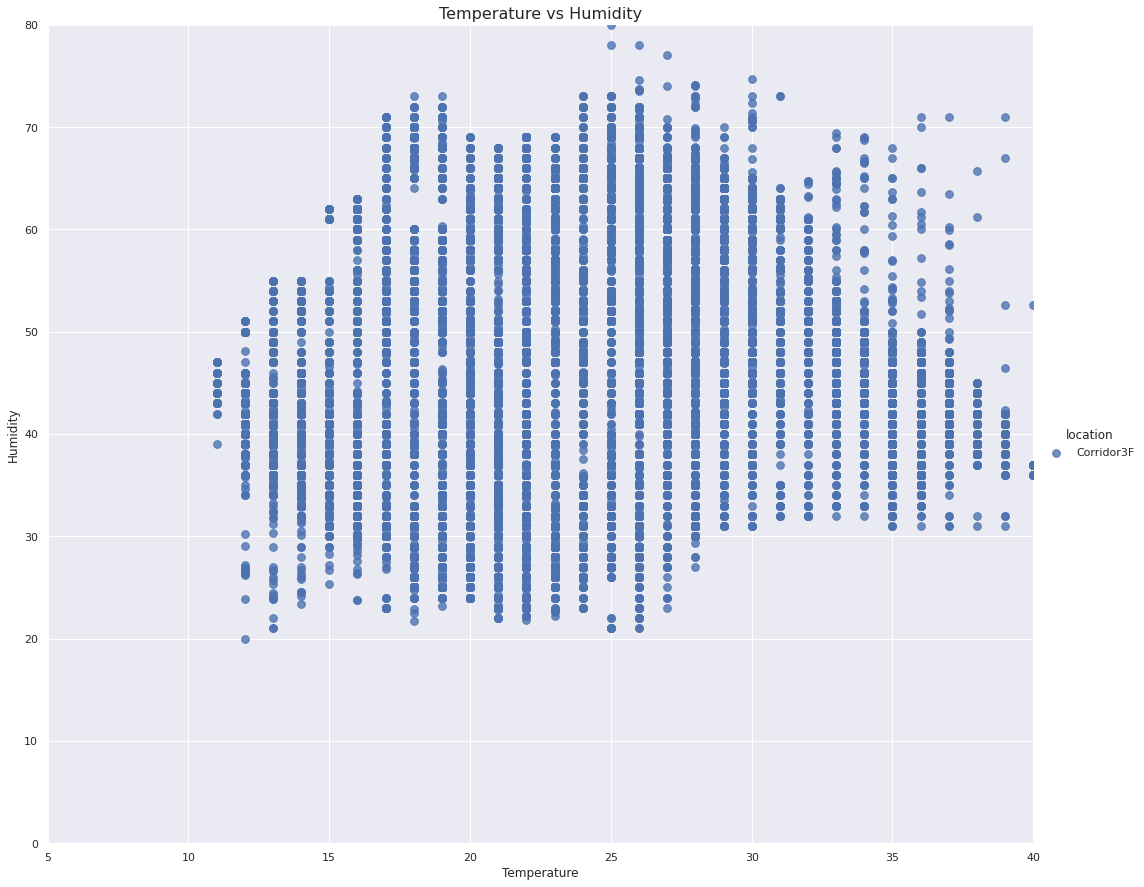

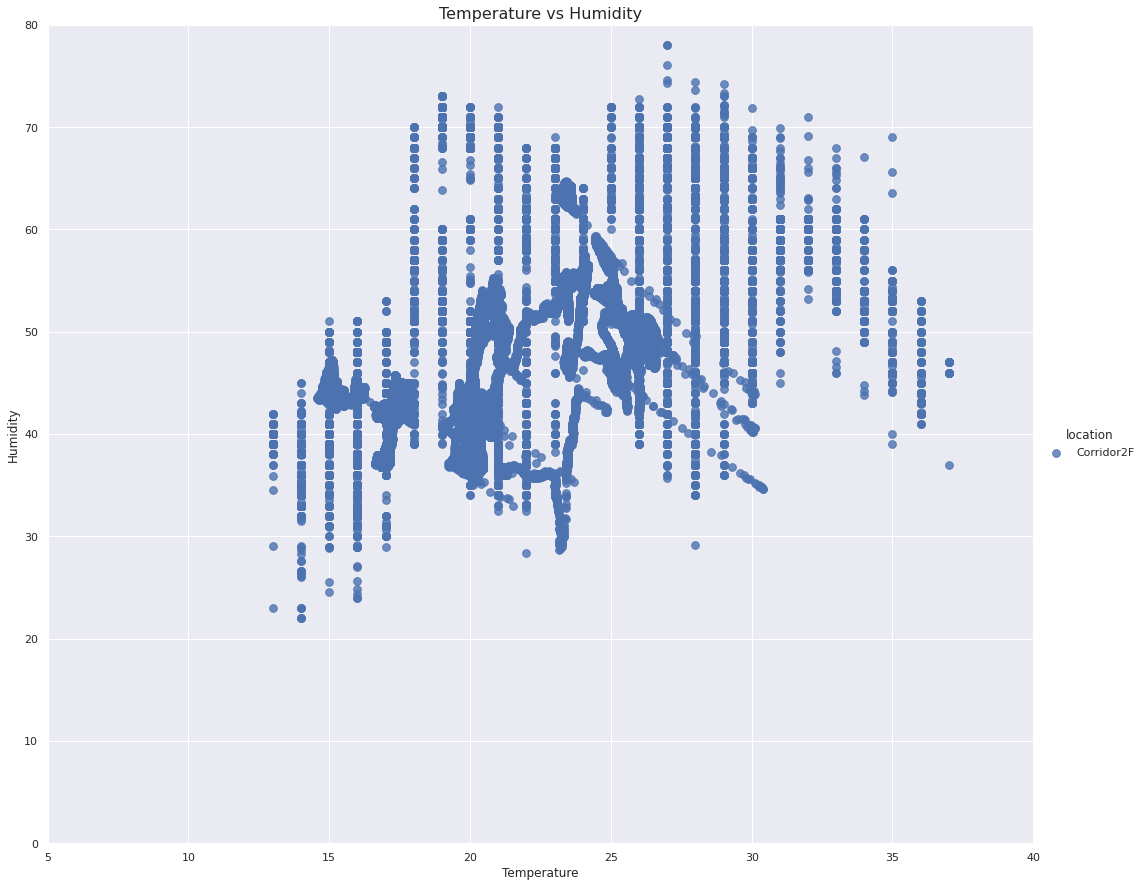

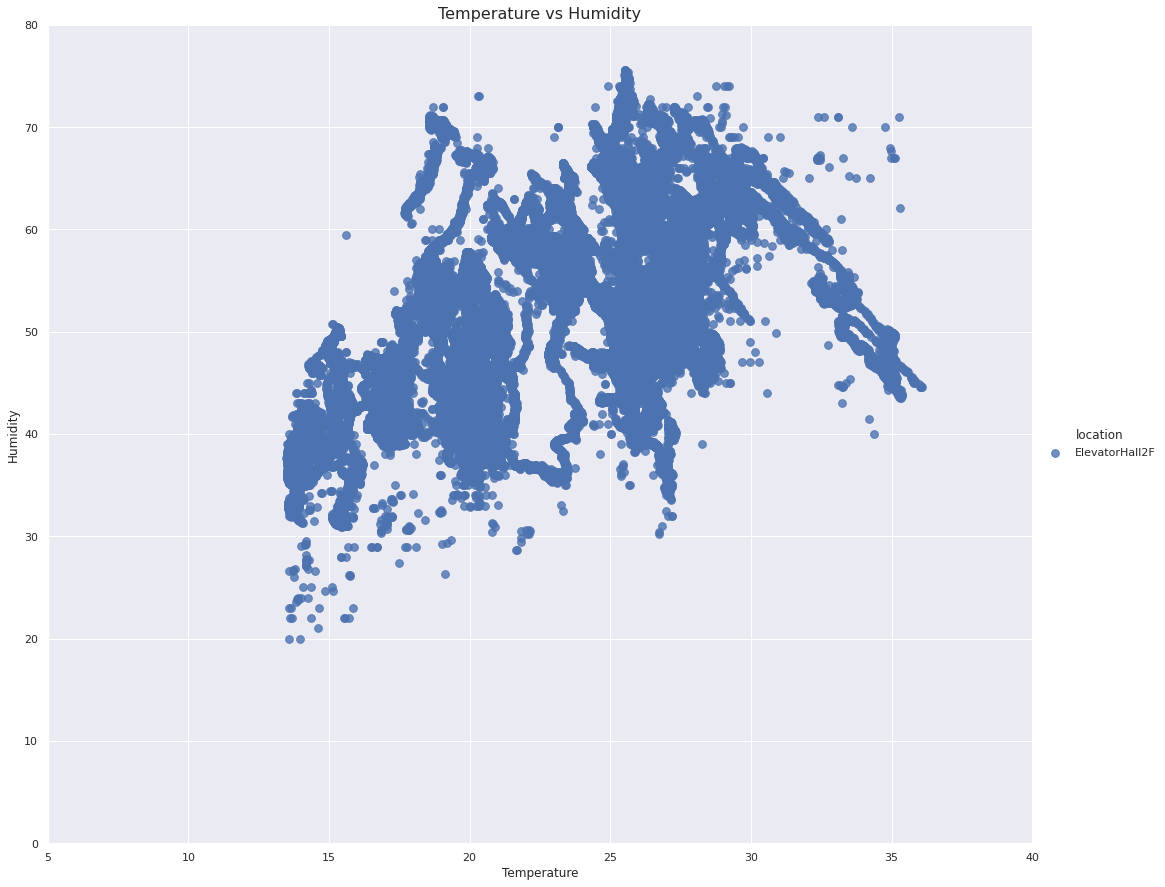

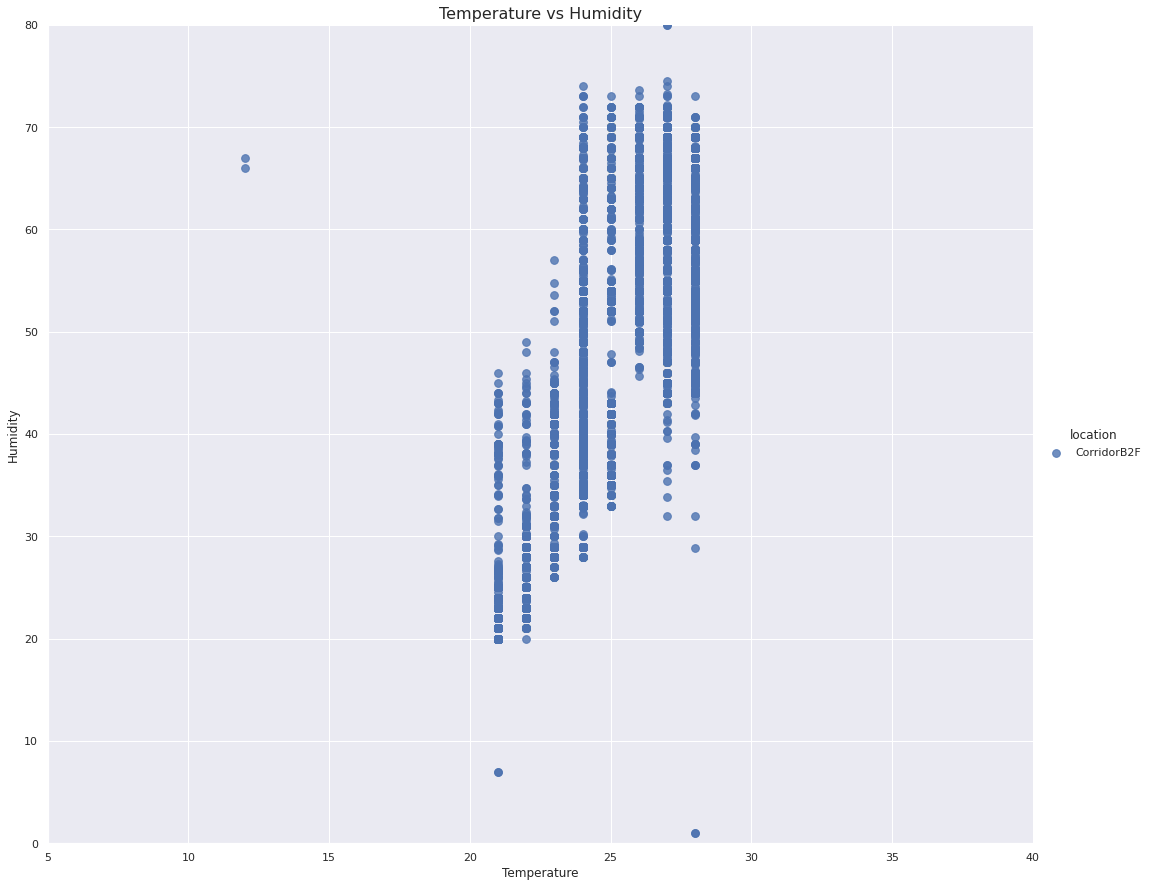

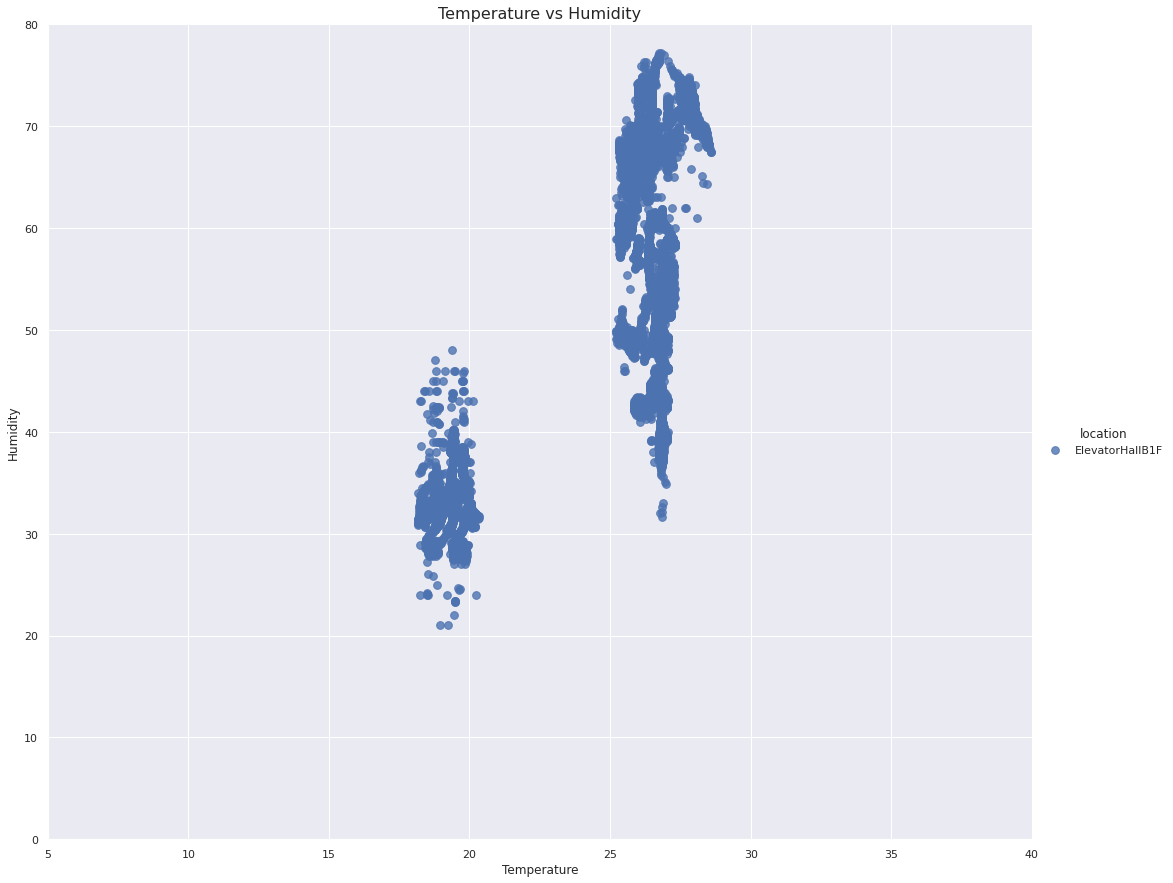

In [193]:
figsize(5, 4)

locations=features['location'].unique()
for each in locations:
    each_loca=features.loc[features["location"]==each]
    sns.lmplot('temperature', 'humidity', 
          hue = 'location', data = each_loca,
          scatter_kws = {'alpha': 0.8, 's': 60}, fit_reg = False,
          size = 12, aspect = 1.2);
    plt.xlabel("Temperature", size = 12)
    plt.xlim(5,40)
    plt.ylim(0,80)
    plt.ylabel('Humidity', size = 12)
    plt.title('Temperature vs Humidity', size = 16);

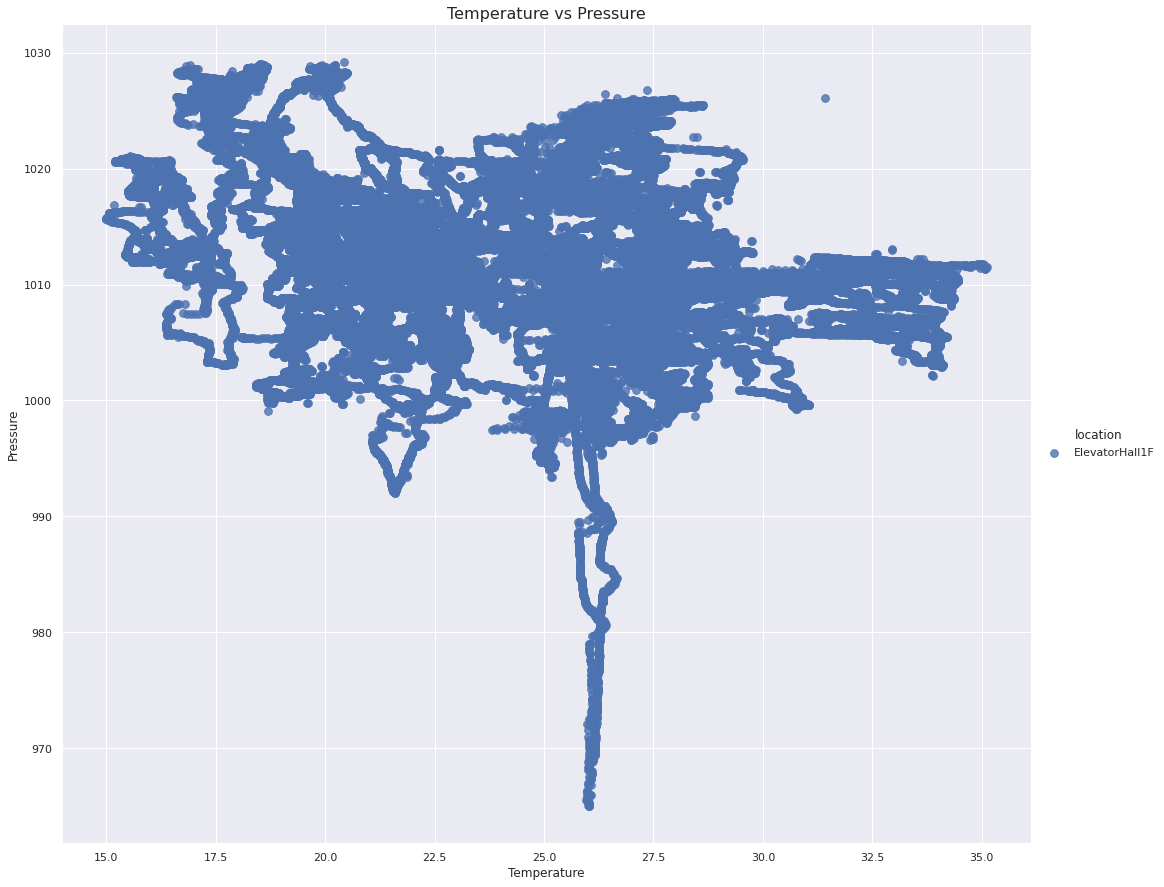

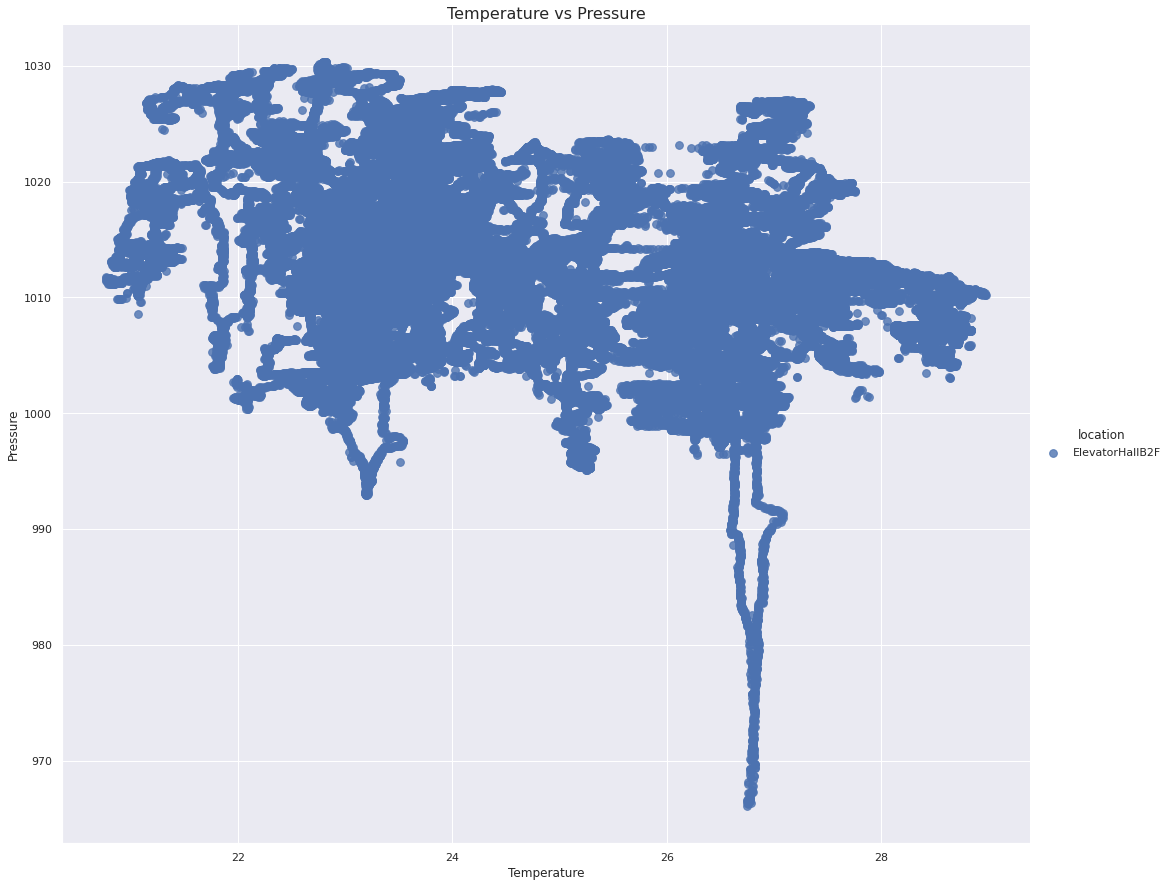

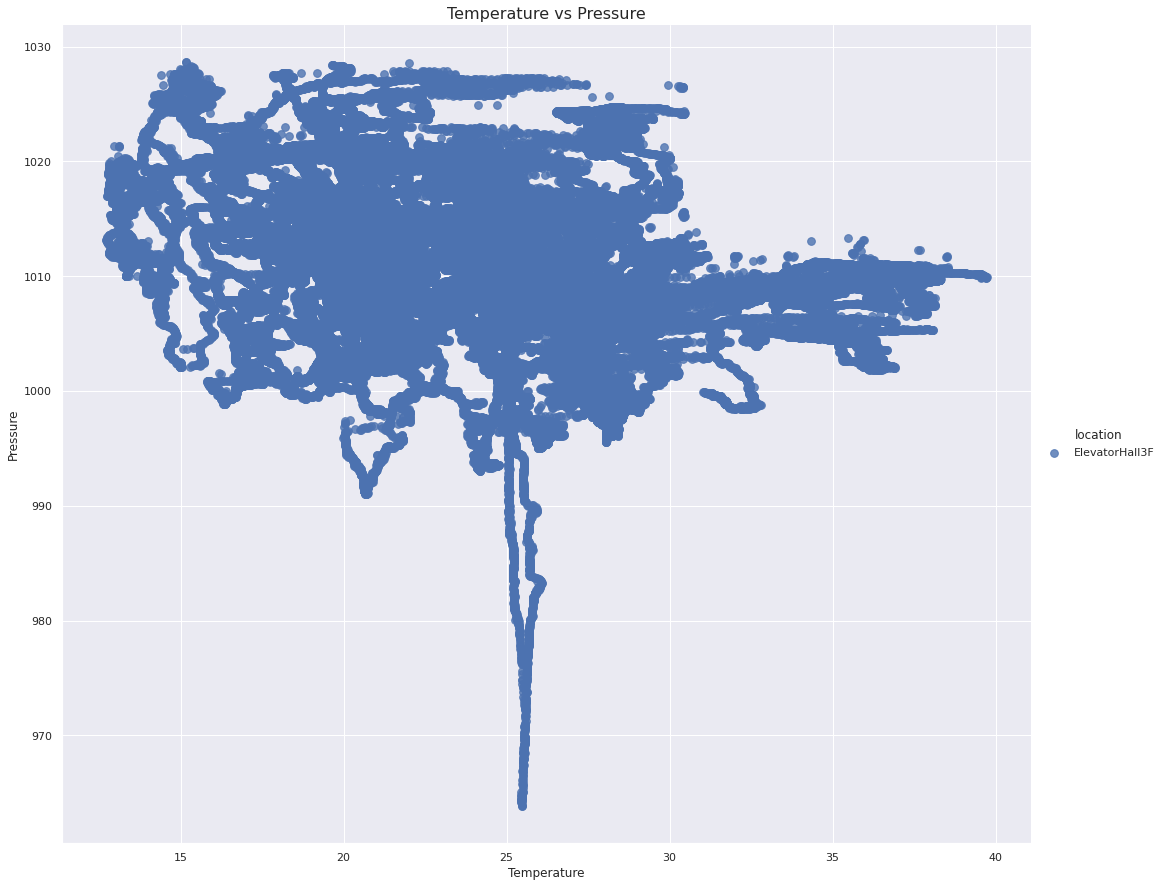

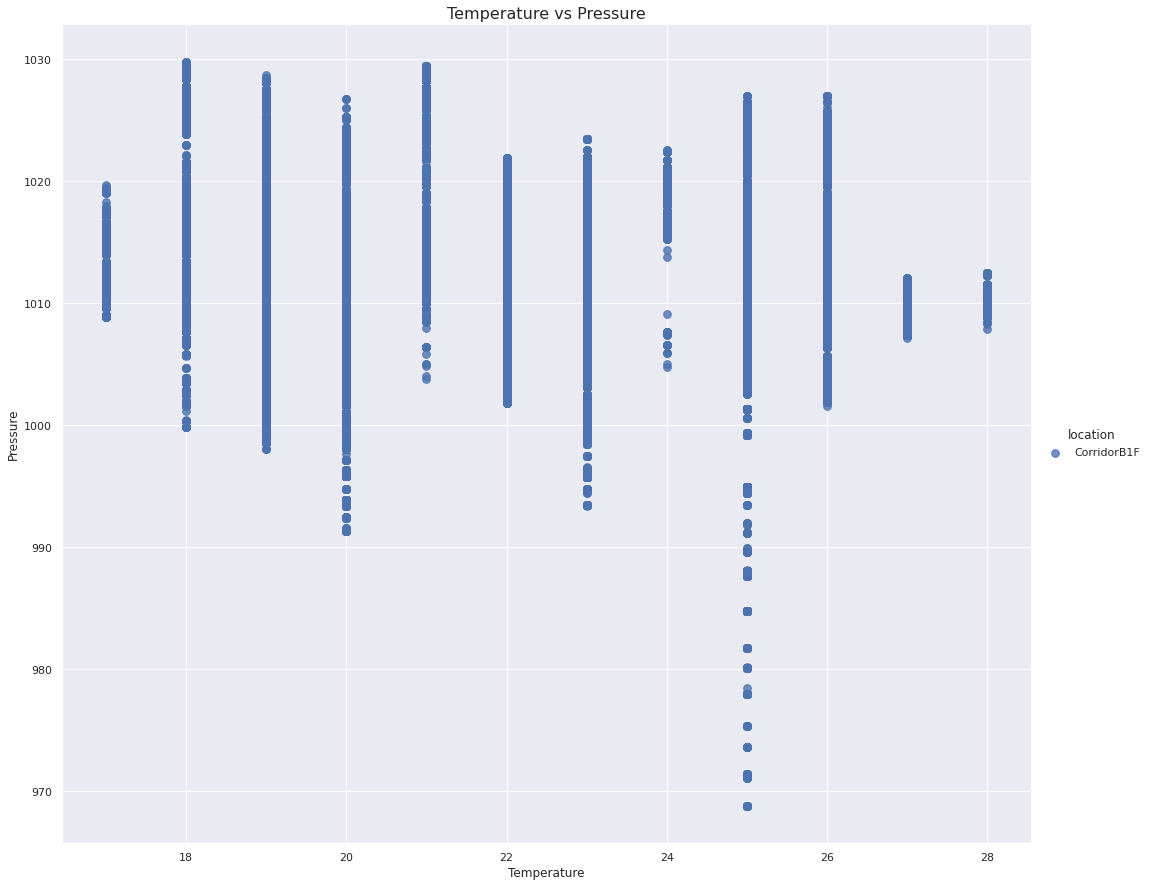

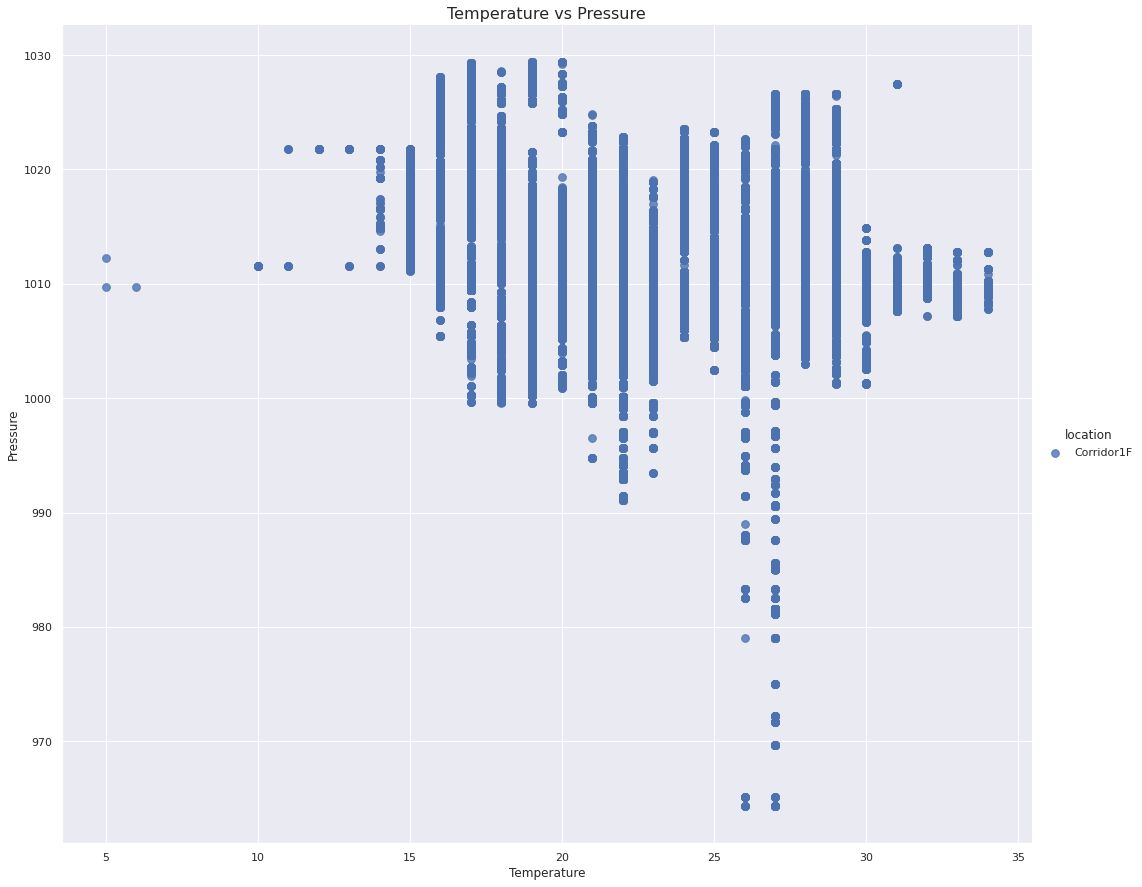

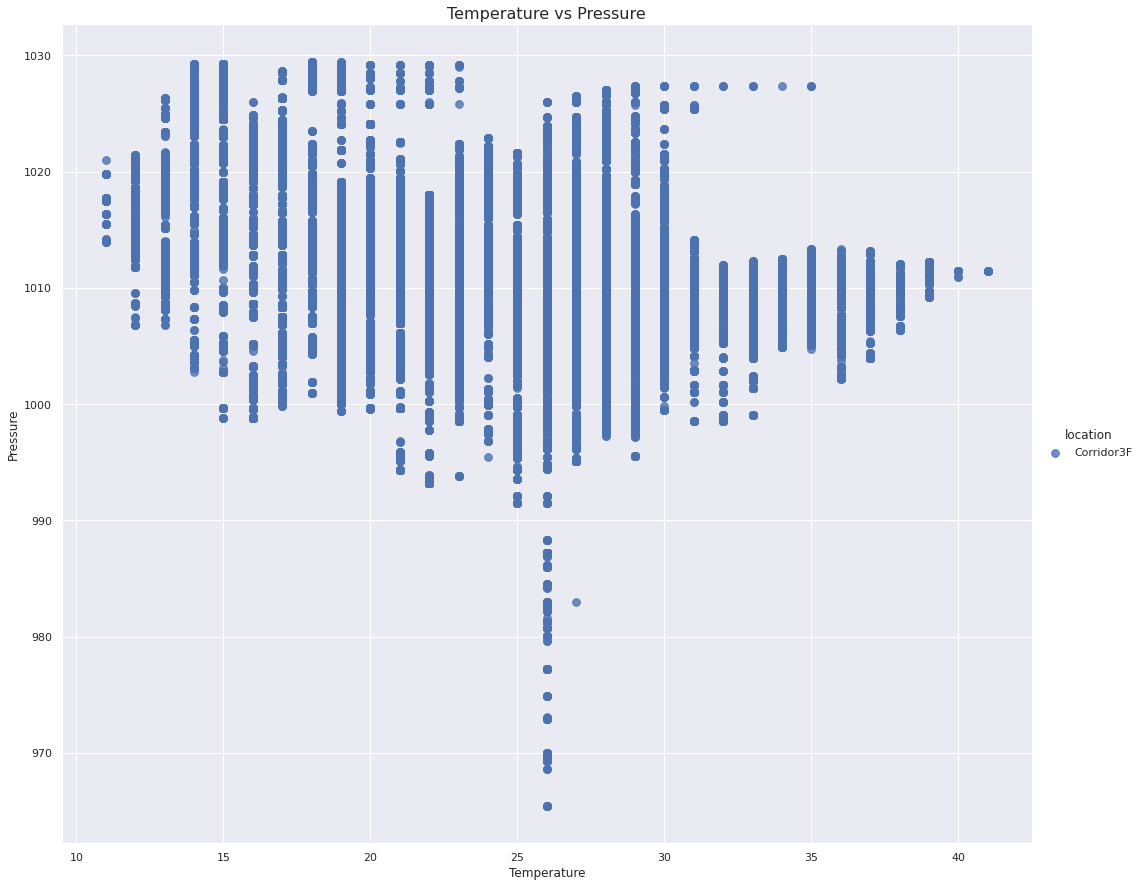

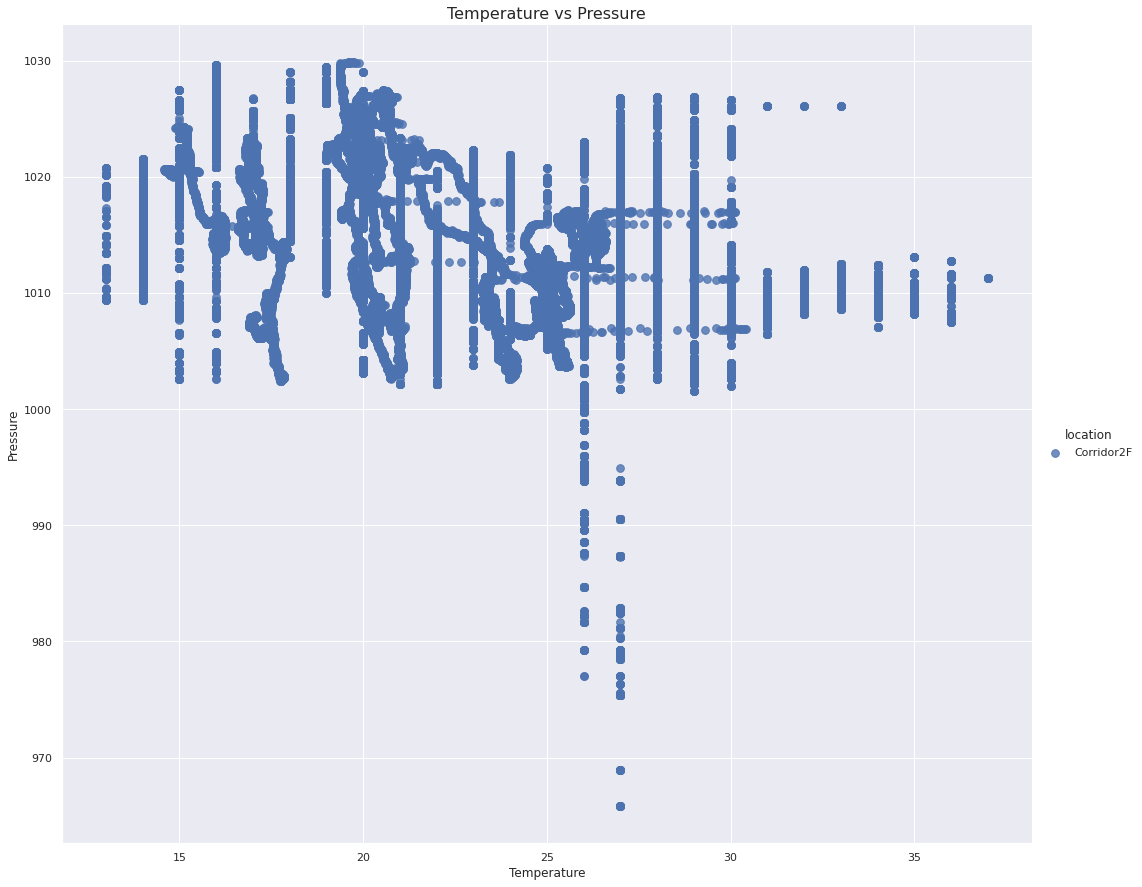

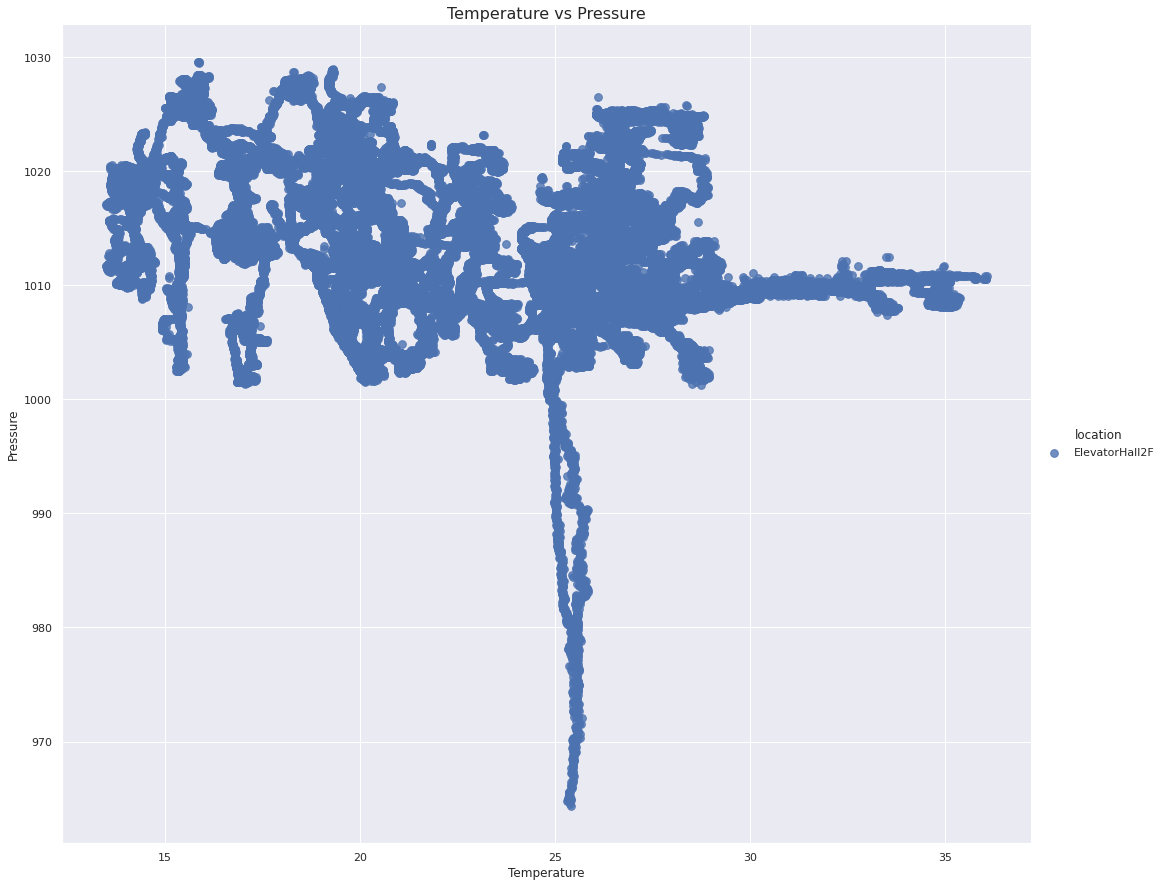

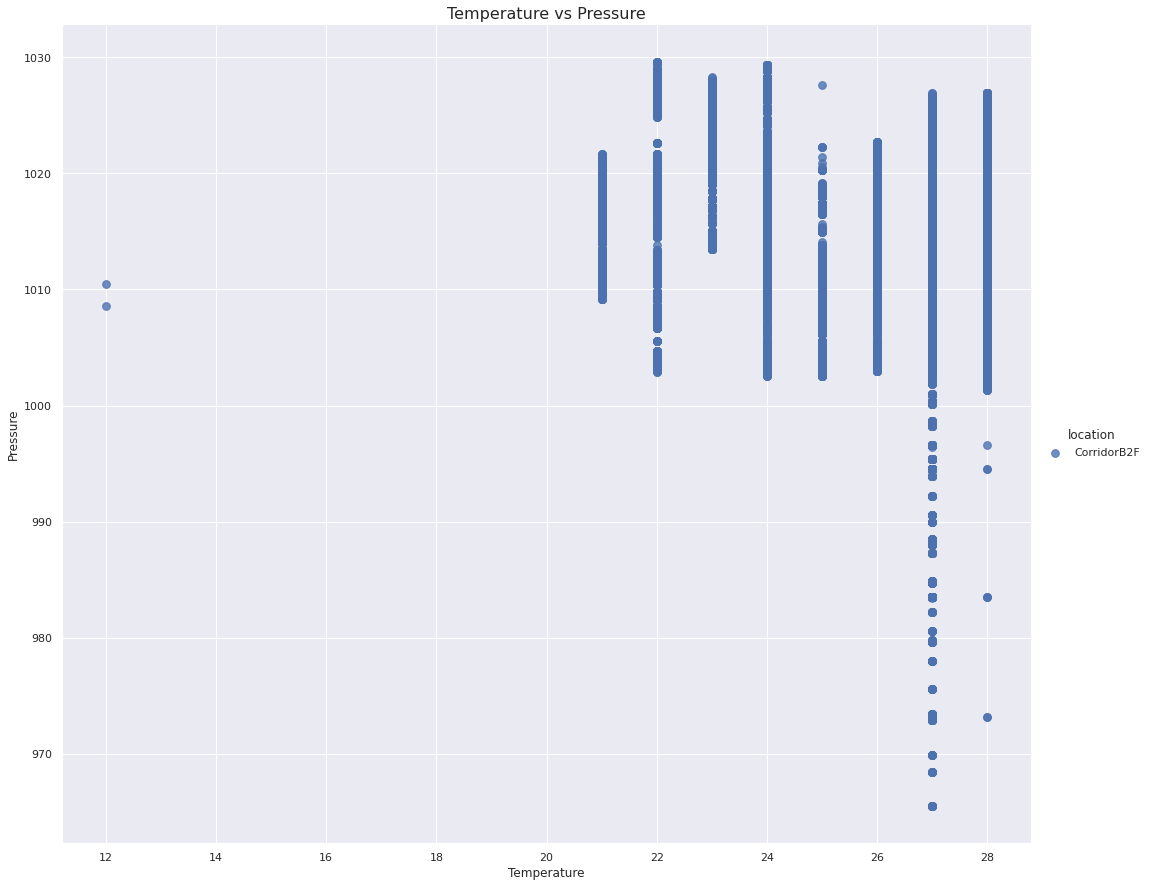

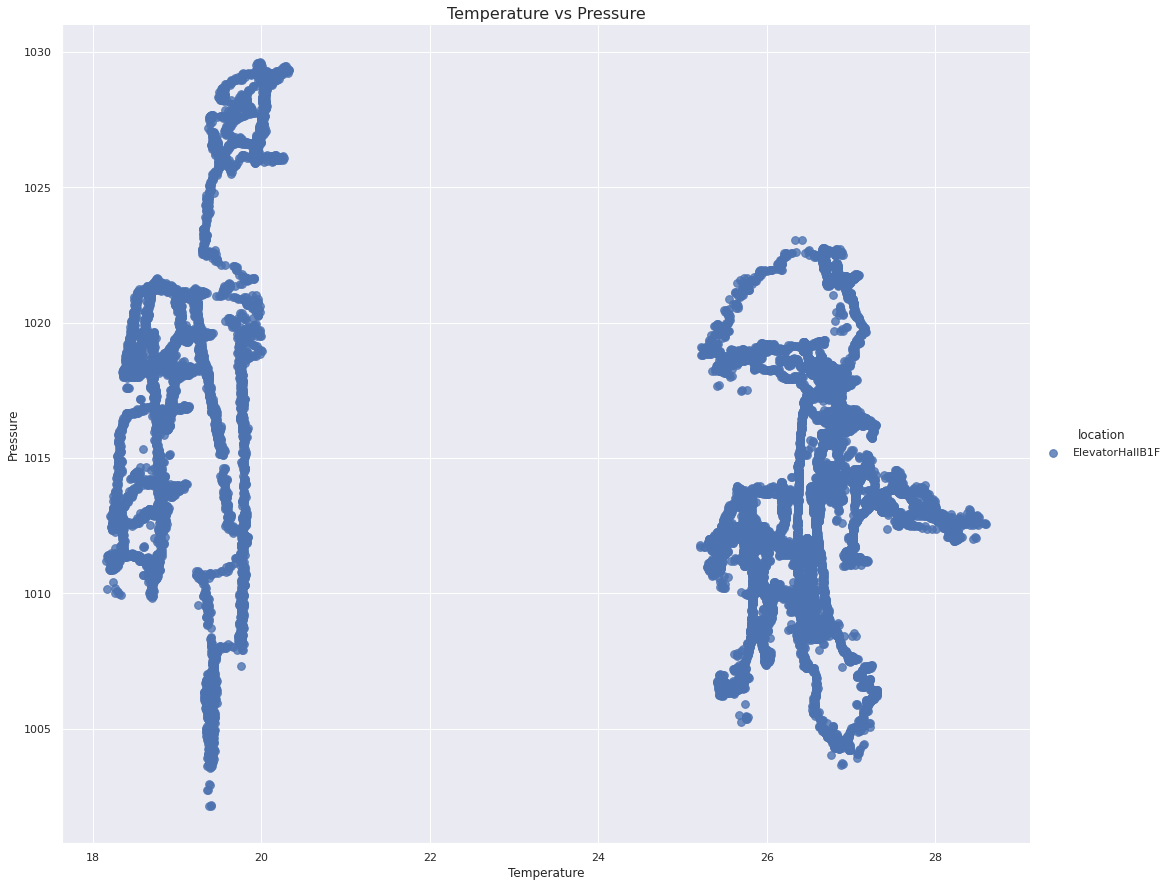

In [194]:
figsize(5, 4)
for each in locations:
    each_loca=features.loc[features["location"]==each]
    sns.lmplot('temperature', 'pressure', 
          hue = 'location', data = each_loca,
          scatter_kws = {'alpha': 0.8, 's': 60}, fit_reg = False,
          size = 12, aspect = 1.2);
    #plt.xlim(5,40)
    #plt.ylim(0,80)
    plt.xlabel("Temperature", size = 12)
    plt.ylabel('Pressure', size = 12)
    plt.title('Temperature vs Pressure', size = 16);

### Pairs Plot

`PairGrid` customize

In [ ]:
# Extract the columns to  plot
plot_data = features[['temperature','humidity','light','pressure']]

# Replace the inf with nan
plot_data = plot_data.replace({np.inf: np.nan, -np.inf: np.nan})

# Drop na values
plot_data = plot_data.dropna()

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3)

# Upper is a scatter plot
grid.map_upper(plt.scatter, color = 'red', alpha = 0.6)

# Diagonal is a histogram
grid.map_diag(plt.hist, color = 'red', edgecolor = 'black')

# Bottom is correlation and density plot
grid.map_lower(corr_func);
grid.map_lower(sns.kdeplot, cmap = plt.cm.Reds)

# Title for entire plot
plt.suptitle('Pairs Plot of Environmental Sensing Data Plot', size = 36, y = 1.02)
plt.savefig('./images/pairplot.png',quality=100,dpi=500)

### 特征工程与特征筛选


通过EDA我们已经对数据有了一定了解，比如我们发现建筑物类型对得分的影响差别很大，经过一些数值变换(log之类的)对结果影响并不大，这些都是我们可以利用的信息，接下来就是最重要的特征工程环节。

一般情况下我们分两步走：特征工程与特征筛选：

- 特征工程：概括性来说就是尽可能的多在数据中提取特征，各种数值变换，特征组合，分解等各种手段齐上阵。


- 特征选择：就是找到最有价值的那些特征作为我们模型的输入，但是之前做了那么多，可能有些是多余的，有些还没被发现，所以这俩阶段都是一个反复在更新的过程。比如我在建模之后拿到了特征重要性，这就为特征选择做了参考，有些不重要的我可以去掉，那些比较重要的，我还可以再想办法让其做更多变换和组合来促进我的模型。所以特征工程并不是一次性就能解决的，需要通过各种结果来反复斟酌。


我们接下来要对数据做一些事情，选择数值特征和种类特征对他们进行log变换与One-hot encode。剔除掉共线特征，可以参考[multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity)


In [ ]:
features.head(5)

In [ ]:
### 剔除共线特征
#在数据中`a` 和 `b`就是要考虑的目标，他俩描述的基本是同一个事，只是计算稍有不用，我们来看下
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model
        to generalize and improves the interpretability of the model.
        
    Inputs: 
        threshold: any features with correlations greater than this value are removed
    
    Output: 
        dataframe that contains only the non-highly-collinear features
    '''
    
    # Dont want to remove correlations between Energy Star Score
    #y = x['score']
    #x = x.drop(columns = ['score'])
    
    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    print("remove ",drops)
    x = x.drop(columns = drops)
#     #x = x.drop(columns = ['Weather Normalized Site EUI (kBtu/ft²)', 
#                           'Water Use (All Water Sources) (kgal)',
#                           'log_Water Use (All Water Sources) (kgal)',
#                           'Largest Property Use Type - Gross Floor Area (ft²)'])
    
    # Add the score back in to the data
    #x['score'] = y
               
    return x

In [45]:
# Remove the collinear features above a specified correlation coefficient
features.shape
features = all_file_data.copy()

#features = remove_collinear_features(features, 0.6);
features.shape

(1259193, 12)

In [46]:
features.head(5)

,location,temperature,new_tsp,humidity,light,pressure,weekday,quarter,month,hour,day,location_no
new_tsp,,,,,,,,,,,,
2020-05-03 00:00:06,ElevatorHall1F,26.768128,2020-05-03 00:00:06,46.338968,NaN,1012.104684,7,2,5,0,3,5
2020-05-03 00:00:18,ElevatorHallB2F,24.168304,2020-05-03 00:00:18,51.785765,NaN,1013.288941,7,2,5,0,3,1
2020-05-03 00:00:22,ElevatorHall3F,29.677198,2020-05-03 00:00:22,38.256116,NaN,1010.999658,7,2,5,0,3,9
2020-05-03 00:00:28,CorridorB1F,22.000000,2020-05-03 00:00:28,57.000000,2.432000,1011.605575,7,2,5,0,3,4
2020-05-03 00:00:34,Corridor1F,27.000000,2020-05-03 00:00:34,50.000000,218.609881,1012.090911,7,2,5,0,3,6


In [21]:
# Separate out the features and targets
targets = pd.DataFrame(features['location_no'])
features =features.drop(columns={'location','location_no'})


# Replace the inf and -inf with nan (required for later imputation)
#features = features.replace({np.inf: np.nan, -np.inf: np.nan})

# Split into 70% training and 30% testing set
X, X_test, y, y_test = train_test_split(features, targets, test_size = 0.3, random_state = 42)

print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)


X.to_csv('DB/new_data/training_features.csv', index = False)
X_test.to_csv('DB/new_data/testing_features.csv', index = False)
y.to_csv('DB/new_data/training_labels.csv', index = False)
y_test.to_csv('DB/new_data/testing_labels.csv', index = False)

(52794, 10)
(22627, 10)
(52794, 1)
(22627, 1)


In [22]:
# Save the no scores, training, and testing data
#no_location.to_csv('DB/data_fill/no_location.csv', index = False)
# X.to_csv('DB/data_fill/training_features.csv', index = False)
# X_test.to_csv('DB/data_fill/testing_features.csv', index = False)
# y.to_csv('DB/data_fill/training_labels.csv', index = False)
# y_test.to_csv('DB/data_fill/testing_labels.csv', index = False)


In [29]:
# Separate out the features and targets
targets = pd.DataFrame(features['floor_no'])
features =features.drop(columns={'location','floor_no'})


# Replace the inf and -inf with nan (required for later imputation)
#features = features.replace({np.inf: np.nan, -np.inf: np.nan})

# Split into 70% training and 30% testing set
X, X_test, y, y_test = train_test_split(features, targets, test_size = 0.3, random_state = 42)

print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)


X.to_csv('DB/floor_data/training_features.csv', index = False)
X_test.to_csv('DB/floor_data/testing_features.csv', index = False)
y.to_csv('DB/floor_data/training_labels.csv', index = False)
y_test.to_csv('DB/floor_data/testing_labels.csv', index = False)

(881435, 10)
(377758, 10)
(881435, 1)
(377758, 1)


In [ ]:
#这部分先不实行

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

stdsc = StandardScaler()


ss= MinMaxScaler()
scale_features = ['pressure', 'light','temperature']#标准化0-1
#hr[scale_features] = ss.fit_transform(hr[scale_features])

features[scale_features] = stdsc.fit_transform(features[scale_features])
features[scale_features] = stdsc.fit_transform(features[scale_features])#标准化

features.head(5)

In [ ]:
# Extract the buildings with no score and the buildings with a score
no_location = features[features['location'].isna()]
location = features[features['location'].notnull()]

print(no_location.shape)
print(location.shape)

### 建立一个Baseline 

### 衡量标准: Mean Absolute Error



In [ ]:
baseline_guess = np.median(y)

print('The baseline guess is a score of %0.2f' % baseline_guess)
print("Baseline Performance on the test set: MAE = %0.4f" % mae(y_test, baseline_guess))

### 结果保存下来，建模再用